In [1]:
devtools::install_github("kasaai/deeptriangle")
devtools::install_github("kasaai/insurance")

ps          (1.7.1     -> 1.7.2    ) [CRAN]
processx    (3.7.0     -> 3.8.0    ) [CRAN]
callr       (3.7.2     -> 3.7.3    ) [CRAN]
matrixStats (0.62.0    -> 0.63.0   ) [CRAN]
vctrs       (0.4.2     -> 0.5.1    ) [CRAN]
RcppEigen   (0.3.3.9.2 -> 0.3.3.9.3) [CRAN]
pkgbuild    (1.2.0     -> 1.4.0    ) [CRAN]
ggplot2     (3.3.6     -> 3.4.0    ) [CRAN]
yaml        (2.3.5     -> 2.3.6    ) [CRAN]
jsonlite    (1.8.2     -> 1.8.3    ) [CRAN]
ggfan       (NA        -> 0.1.3    ) [CRAN]
keras       (2.6.0     -> 2.9.0    ) [CRAN]


Installing 12 packages: ps, processx, callr, matrixStats, vctrs, RcppEigen, pkgbuild, ggplot2, yaml, jsonlite, ggfan, keras

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘vctrs’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘jsonlite’ had non-zero exit status”
Warning message in i.p(...):
“installation of package ‘ggplot2’ had non-zero exit status”


✔  checking for file ‘/tmp/RtmpXaExFe/remotese479aa7d0/kasaai-deeptriangle-ab2dd55/DESCRIPTION’
─  preparing ‘deeptriangle’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘deeptriangle_0.3.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




vctrs (0.4.2 -> 0.5.1) [CRAN]


Installing 1 packages: vctrs

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in i.p(...):
“installation of package ‘vctrs’ had non-zero exit status”


✔  checking for file ‘/tmp/RtmpXaExFe/remotese7107b32c/kasaai-insurance-f323fa1/DESCRIPTION’
─  preparing ‘insurance’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘insurance_0.2.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
install.packages("GA")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(recipes)
library(insurance)
library(tidyverse)
library(deeptriangle)
library(keras)
library(tensorflow)
library(GA)
library(tictoc)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.5
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.2.1     ✔ forcats 0.5.2
✔ readr   2.1.3     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ stringr::fixed() masks recipes::fixed()
✖ dplyr::lag()     masks stats::lag()
Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Package 'GA' version 3.2.3
Type 'citation("GA")' for citing this R package

In [4]:
#' Given a time series, return a list
#'  where each element is a vector representing a window
#'  of the time series determined by the offsets
make_series <- function(v, start_offset, end_offset, na_pad = -99) {
  prepad_mask <- function(v, l = 9) {
    length_diff <- l - length(v)
    if (length_diff > 0) {
      c(rep(na_pad, length_diff), v)
    } else {
      v
    }
  }
  
  purrr::map(
    seq_along(v),
    function(x) {
      start <- max(0, x + start_offset)
      end <- max(0, x + end_offset)
      out <- v[start:end]
      ifelse(is.na(out), na_pad, out)
    } %>%
      prepad_mask()
  )
}

mutate_series <- function(data, timesteps = 9) {
  data %>%
    dplyr::group_by(.data$lob, .data$group_code, .data$accident_year) %>%
    dplyr::arrange(.data$lob, .data$group_code, .data$accident_year, .data$development_lag) %>%
    mutate(
      paid_lags = make_series(incremental_paid, -timesteps, -1),
      case_lags = make_series(case_reserves, -timesteps, -1),
      paid_target = make_series(incremental_paid, 0, timesteps - 1),
      case_target = make_series(case_reserves, 0, timesteps - 1),
    ) %>%
    ungroup()
}

prep_keras_data <- function(data, company_index_recipe) {
  lags <- data %>%
    select(.data$paid_lags, .data$case_lags) %>%
    purrr::transpose() %>%
    purrr::map(~ array(unlist(.x), dim = c(1, 9, 2))) %>%
    abind::abind(along = 1) %>%
    unname()
  
  target_paid <- data %>%
    pull(.data$paid_target) %>%
    flatten_dbl() %>%
    array_reshape(c(nrow(data), 9, 1))
  
  target_case <- data %>%
    pull(.data$case_target) %>%
    flatten_dbl() %>%
    array_reshape(c(nrow(data), 9, 1))
  
  company_input <- bake(company_index_recipe, data) %>% as.matrix()
  
  list(
    x = list(
      ay_seq_input = lags, company_input = company_input
    ),
    y = list(
      paid_output = target_paid,
      case_reserves_output = target_case
    )
  )
}

masked_mse <- function(mask_value) {
  function(y_true, y_pred) {
    keep_value <- k_cast(k_not_equal(y_true, mask_value), k_floatx())
    sum_squared_error <- k_sum(
      k_square(keep_value * (y_true - y_pred)),
      axis = 2
    )
    sum_squared_error / k_sum(keep_value, axis = 2)
  }
}

transform_preds <- function(preds) {
  rows <- 1:dim(preds[[1]])[[1]]
  list(
    # predicted_cumulative_loss = map(rows, ~ preds[[1]][, , 2][.x, ]),
    predicted_loss = map(rows, ~ preds[[1]][, , 1][.x, ]),
    predicted_os = map(rows, ~ preds[[2]][, , 1][.x, ])
  ) %>%
    as_tibble()
}

extract_keras_data <- function(data, lob) {
  data %>%
    filter(lob == !!lob) %>%
    pull(.data$keras_data) %>%
    flatten()
}

extract_data <- function(data, lob) {
  data %>%
    filter(lob == !!lob) %>%
    unnest(.data$data)
}

compute_predictions <- function(model, test_data, lob) {
  predictions <- model %>%
    predict(extract_keras_data(test_data, lob)$x) %>%
    transform_preds()
  
  test_data %>%
    unnest(data) %>%
    select(group_code, accident_year, development_lag) %>%
    bind_cols(predictions) %>%
    unnest(predicted_loss, predicted_os) %>%
    group_by(group_code, accident_year) %>%
    mutate(development_lag = development_lag + row_number() - 1) %>%
    filter(development_lag <= 10) %>%
    right_join(
      data_with_features %>%
        filter(lob == !!lob),
      by = c("group_code", "accident_year", "development_lag")
    ) %>%
    arrange(group_code, accident_year, development_lag) %>%
    mutate(
      predicted_os = if_else(
        is.na(predicted_os),
        case_reserves, predicted_os
      ),
      predicted_loss = if_else(
        is.na(predicted_loss),
        incremental_paid, predicted_loss
      )
    ) %>%
    mutate(
      predicted_cumulative_loss = cumsum(predicted_loss) * earned_premium_net,
      predicted_os = predicted_os * earned_premium_net,
      case_reserves_actual = case_reserves_actual * earned_premium_net
    ) %>%
    ungroup() %>%
    gather(
      "type", "value", predicted_cumulative_loss, predicted_os,
      cumulative_paid_loss, case_reserves_actual,
      na.rm = TRUE
    ) %>%
    mutate(
      obs_type = case_when(
        grepl("predicted", type) ~ "prediction",
        calendar_year <= 1997 ~ "observed",
        calendar_year > 1997 ~ "holdout",
        TRUE ~ "observed"
      )
    )
}

In [5]:
data(schedule_p)

data_with_features <- schedule_p %>%
  right_join(dt_group_codes, by = c("lob", "group_code")) %>%
  mutate(case_reserves = incurred_loss - cumulative_paid_loss) %>%
  group_by(lob, group_code, accident_year) %>%
  arrange(lob, group_code, accident_year, development_lag) %>%
  mutate(
    incremental_paid_actual = incremental_paid_loss,
    incremental_paid = ifelse(
      calendar_year <= 1997,
      incremental_paid_actual, NA_real_
    ),
    cumulative_paid_actual = cumulative_paid_loss,
    cumulative_paid = ifelse(
      calendar_year <= 1997,
      cumulative_paid_actual, NA_real_
    ),
    case_reserves_actual = case_reserves,
    case_reserves = ifelse(
      calendar_year <= 1997,
      case_reserves_actual,
      NA_real_
    )
  ) %>%
  ungroup() %>%
  mutate(
    bucket = case_when(
      calendar_year <= 1995 & development_lag > 1 ~ "train",
      calendar_year > 1995 & calendar_year <= 1997 &
        development_lag > 1 ~ "validation",
      calendar_year > 1997 ~ "test"
    )
  ) %>%
  mutate(
    incremental_paid = incremental_paid / earned_premium_net,
    incremental_paid_actual = incremental_paid_actual / earned_premium_net,
    cumulative_paid = cumulative_paid / earned_premium_net,
    cumulative_paid_actual = cumulative_paid_actual / earned_premium_net,
    case_reserves = case_reserves / earned_premium_net,
    case_reserves_actual = case_reserves_actual / earned_premium_net
  )

# Recipe for indexing company code
company_index_recipe <- recipe(~ group_code, data = data_with_features) %>%
  step_integer(group_code, zero_based = TRUE) %>%
  prep()

data_keras <- bind_rows(
  validation_data = data_with_features %>%
    filter(bucket %in% c("train", "validation") | development_lag == 1) %>%
    mutate_series() %>%
    filter(bucket == "validation") %>%
    group_by(lob) %>%
    nest() %>%
    mutate(keras_data = map(data, ~ prep_keras_data(.x, company_index_recipe))),
  full_training_data = data_with_features %>%
    filter(bucket %in% c("train", "validation") | development_lag == 1) %>%
    mutate_series() %>%
    filter(bucket %in% c("train", "validation")) %>%
    group_by(lob) %>%
    nest() %>%
    mutate(keras_data = map(data, ~ prep_keras_data(.x, company_index_recipe))),
  test_data = data_with_features %>%
    filter(calendar_year <= 1998) %>%
    mutate_series() %>%
    filter(bucket == "test", calendar_year == 1998) %>%
    group_by(lob) %>%
    nest() %>%
    mutate(keras_data = map(data, ~ prep_keras_data(.x, company_index_recipe))),
  .id = "data_type"
)

Warning message:
“Use of .data in tidyselect expressions was deprecated in tidyselect 1.2.0.
ℹ Please use `"paid_lags"` instead of `.data$paid_lags`”
Warning message:
“Use of .data in tidyselect expressions was deprecated in tidyselect 1.2.0.
ℹ Please use `"case_lags"` instead of `.data$case_lags`”


In [6]:
#' Compute performance metrics
#'
#' @param predictions Predictions data frame.
#' @export
dt_compute_metrics <- function(predictions) {
  predictions %>%
    dplyr::filter(
      .data$development_lag == 10,
      .data$type %in% c("cumulative_paid_loss", "predicted_cumulative_loss")
    ) %>%
    dplyr::group_by(.data$lob, .data$group_code, .data$type, .data$run_id) %>%
    dplyr::summarize(ultimate = sum(.data$value)) %>%
    dplyr::group_by(.data$lob, .data$group_code, .data$type) %>%
    dplyr::summarize(ultimate = mean(.data$ultimate)) %>%
    tidyr::spread(.data$type, .data$ultimate) %>%
    dplyr::mutate(
      pct_error = (.data$predicted_cumulative_loss - .data$cumulative_paid_loss) /
        .data$cumulative_paid_loss) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(.data$lob) %>%
    dplyr::summarize(
      mape = mean(abs(.data$pct_error)),
      rmspe = sqrt(mean(.data$pct_error ^ 2))
    ) %>%
    dplyr::mutate(model = "DeepTriangle")
}

#' Tabulate performance metrics for all models
#'
#' @param data Model results in tidy format.
#' @param metric Performance metric.
#' @export
dt_tabulate_metrics <- function(data, metric = c("mape", "rmspe")) {
  metric <- rlang::arg_match(metric)
  data %>%
    dplyr::filter(metric == !!metric) %>%
    dplyr::select(-.data$metric) %>%
    tidyr::spread(.data$model,.data$ value) %>%
    dplyr::select(
      .data$lob, .data$DeepTriangle
    )
}

In [7]:
dt_model2 <- function(rdo1,rdo2,do1,do2) {
  ay_seq_input <- layer_input(shape = list(9, 2), name = "ay_seq_input")
  company_code_input <- layer_input(shape = 1, name = "company_input")
  company_code_embedding <- company_code_input %>%
    layer_embedding(200, 49, name = "company_code_embedding") %>%
    layer_flatten()%>%
    layer_repeat_vector(9)
  
  encoded <- ay_seq_input %>%
    layer_masking(-99) %>%
    layer_gru(units = 128, dropout = 0.2, recurrent_dropout = rdo1)
  
  ay_decoded <- encoded %>%
    layer_repeat_vector(9) %>%
    layer_gru(128, return_sequences = TRUE, dropout = 0.2, recurrent_dropout = rdo2)
  
  decoded=layer_concatenate(list(ay_decoded, company_code_embedding))
    
  case_reserves_output <- decoded %>%
    time_distributed(layer_dense(units = 64, activation = "relu")) %>%
    time_distributed(layer_dropout(rate = do1)) %>%
    time_distributed(layer_dense(units = 1, activation = "relu"), name = "case_reserves_output")
  
  paid_output <- decoded %>%
    time_distributed(layer_dense(units = 64, activation = "relu")) %>%
    time_distributed(layer_dropout(rate = do2)) %>%
    time_distributed(layer_dense(units = 1, activation = "relu"), name = "paid_output")
  
  model <- keras_model(
    inputs = c(ay_seq_input, company_code_input),
    outputs = c(paid_output, case_reserves_output)
  )
  
  model
}

In [8]:
fit_DT=function(rdo1,rdo2,do1,do2,lr)
    {
    lobs <- c("commercial_auto","other_liability", "private_passenger_auto", "workers_compensation")

results <- map_df(lobs, function(lob) {
  data_lob <- data_keras %>%
    filter(lob == !!lob)
  full_training_data_keras <- data_lob %>%
    filter(data_type == "full_training_data") %>%
    pull(keras_data) %>%
    flatten()
  validation_data_keras <- data_lob %>%
    filter(data_type == "validation_data") %>%
    pull(keras_data) %>%
    flatten()
  test_data <- data_lob %>%
    filter(data_type == "test_data")
  
  map_df(1:10, function(run_id) {
    if (run_id %% 10 == 1) k_clear_session()
    cat(sprintf("Training LOB %s run %s: ", lob, run_id))
    start_time <- Sys.time()
    model <- dt_model2(rdo1,rdo2,do1,do2)
    model %>%
      compile(
        optimizer = optimizer_adam(learning_rate = lr, amsgrad = TRUE),
        loss = list(masked_mse(-99), masked_mse(-99)),
        loss_weights = c(0.5, 0.5)
      )
    
    cb <- callback_early_stopping(min_delta = 0.001, patience = 30, mode = "min", restore_best_weights = TRUE)
    
    history <- model %>%
      fit(
        x = full_training_data_keras$x,
        y = full_training_data_keras$y,
        validation_data = unname(validation_data_keras),
        batch_size = 2250,
        epochs = 150,
        callbacks = list(cb),
        verbose = 0
      )
    
    training_time <- as.integer(Sys.time() - start_time)
    
    cat(sprintf("training for %d epochs took %d seconds at %s", cb$stopped_epoch, training_time, Sys.time()), "\n")
    
    predictions_table <- compute_predictions(model, test_data, lob) %>%
      mutate(lob = !!lob, run_id = !!run_id)
    
    tibble(
      lob = lob,
      run_id = run_id,
      training_time = training_time,
      predictions_table = list(predictions_table),
      trained_epochs = cb$stopped_epoch
    )
  })
})
    predictions_table <- results  %>%
      pull(predictions_table) %>%
      bind_rows()
    
    model_results <- dt_compute_metrics(predictions_table) %>%
  gather(metric, value, mape, rmspe)
    MAPE1=model_results$value[1]
    MAPE2=model_results$value[2]
    MAPE3=model_results$value[3]
    MAPE4=model_results$value[4]
    cat("MAPE1 score:", MAPE1)
    cat("\n")
    cat("MAPE2 score:", MAPE2)
    cat("\n")
    cat("MAPE3 score:", MAPE3)
    cat("\n")
    cat("MAPE4 score:", MAPE4)
    cat("\n")
    MAPE=(0.25*MAPE1)+(0.25*MAPE2)+(0.25*MAPE3)+(0.25*MAPE4)
    return(-MAPE)
}

Warning message in ga(type = "real-valued", fitness = function(x) fit_DT(x[1], x[2], :
“The population size is less than 10.”
Loaded Tensorflow version 2.6.5



Training LOB commercial_auto run 1: training for 60 epochs took 13 seconds at 2022-11-29 10:46:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 52 epochs took 8 seconds at 2022-11-29 10:46:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 69 epochs took 9 seconds at 2022-11-29 10:46:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 49 epochs took 8 seconds at 2022-11-29 10:46:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 57 epochs took 8 seconds at 2022-11-29 10:47:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 10:47:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 58 epochs took 8 seconds at 2022-11-29 10:47:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 50 epochs took 7 seconds at 2022-11-29 10:47:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 46 epochs took 7 seconds at 2022-11-29 10:47:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 10:47:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 53 epochs took 8 seconds at 2022-11-29 10:47:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 66 epochs took 8 seconds at 2022-11-29 10:48:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 68 epochs took 9 seconds at 2022-11-29 10:48:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 58 epochs took 8 seconds at 2022-11-29 10:48:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 53 epochs took 8 seconds at 2022-11-29 10:48:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 79 epochs took 10 seconds at 2022-11-29 10:48:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 76 epochs took 10 seconds at 2022-11-29 10:49:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 97 epochs took 11 seconds at 2022-11-29 10:49:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 68 epochs took 8 seconds at 2022-11-29 10:49:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 49 epochs took 9 seconds at 2022-11-29 10:49:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 7 seconds at 2022-11-29 10:50:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 49 epochs took 8 seconds at 2022-11-29 10:50:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 10:50:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 57 epochs took 8 seconds at 2022-11-29 10:50:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 52 epochs took 9 seconds at 2022-11-29 10:50:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-11-29 10:50:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 10:50:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 8 seconds at 2022-11-29 10:51:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 10:51:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 10:51:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 42 epochs took 7 seconds at 2022-11-29 10:51:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 52 epochs took 7 seconds at 2022-11-29 10:51:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 49 epochs took 9 seconds at 2022-11-29 10:51:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 7 seconds at 2022-11-29 10:52:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 65 epochs took 9 seconds at 2022-11-29 10:52:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 52 epochs took 7 seconds at 2022-11-29 10:52:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 47 epochs took 7 seconds at 2022-11-29 10:52:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 59 epochs took 8 seconds at 2022-11-29 10:52:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 48 epochs took 7 seconds at 2022-11-29 10:52:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 42 epochs took 7 seconds at 2022-11-29 10:52:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05471073
MAPE2 score: 0.10905
MAPE3 score: 0.0237594
MAPE4 score: 0.04951937
Training LOB commercial_auto run 1: training for 49 epochs took 9 seconds at 2022-11-29 10:53:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 62 epochs took 8 seconds at 2022-11-29 10:53:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 45 epochs took 7 seconds at 2022-11-29 10:53:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 63 epochs took 8 seconds at 2022-11-29 10:53:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 44 epochs took 8 seconds at 2022-11-29 10:53:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 53 epochs took 7 seconds at 2022-11-29 10:53:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 63 epochs took 8 seconds at 2022-11-29 10:54:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 70 epochs took 9 seconds at 2022-11-29 10:54:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 10:54:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 41 epochs took 6 seconds at 2022-11-29 10:54:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 73 epochs took 9 seconds at 2022-11-29 10:54:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 79 epochs took 10 seconds at 2022-11-29 10:54:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 76 epochs took 9 seconds at 2022-11-29 10:55:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 63 epochs took 9 seconds at 2022-11-29 10:55:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 61 epochs took 8 seconds at 2022-11-29 10:55:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 66 epochs took 9 seconds at 2022-11-29 10:55:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 78 epochs took 10 seconds at 2022-11-29 10:55:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 75 epochs took 9 seconds at 2022-11-29 10:56:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 73 epochs took 9 seconds at 2022-11-29 10:56:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 55 epochs took 8 seconds at 2022-11-29 10:56:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 40 epochs took 7 seconds at 2022-11-29 10:56:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 49 epochs took 7 seconds at 2022-11-29 10:56:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 10:57:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 7 seconds at 2022-11-29 10:57:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 49 epochs took 8 seconds at 2022-11-29 10:57:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 66 epochs took 9 seconds at 2022-11-29 10:57:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 6 seconds at 2022-11-29 10:57:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 40 epochs took 6 seconds at 2022-11-29 10:57:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 68 epochs took 9 seconds at 2022-11-29 10:57:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 61 epochs took 8 seconds at 2022-11-29 10:58:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 40 epochs took 7 seconds at 2022-11-29 10:58:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 47 epochs took 7 seconds at 2022-11-29 10:58:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 61 epochs took 9 seconds at 2022-11-29 10:58:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-11-29 10:58:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 48 epochs took 7 seconds at 2022-11-29 10:58:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 64 epochs took 9 seconds at 2022-11-29 10:59:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 57 epochs took 8 seconds at 2022-11-29 10:59:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 60 epochs took 9 seconds at 2022-11-29 10:59:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 59 epochs took 8 seconds at 2022-11-29 10:59:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 51 epochs took 7 seconds at 2022-11-29 10:59:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05433243
MAPE2 score: 0.1134127
MAPE3 score: 0.02420984
MAPE4 score: 0.04985819
Training LOB commercial_auto run 1: training for 65 epochs took 8 seconds at 2022-11-29 10:59:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 39 epochs took 7 seconds at 2022-11-29 11:00:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 57 epochs took 8 seconds at 2022-11-29 11:00:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 46 epochs took 7 seconds at 2022-11-29 11:00:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 42 epochs took 7 seconds at 2022-11-29 11:00:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 62 epochs took 14 seconds at 2022-11-29 11:00:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 11:01:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 59 epochs took 8 seconds at 2022-11-29 11:01:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 51 epochs took 8 seconds at 2022-11-29 11:01:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 11:01:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 51 epochs took 8 seconds at 2022-11-29 11:01:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 49 epochs took 8 seconds at 2022-11-29 11:01:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 43 epochs took 7 seconds at 2022-11-29 11:01:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 43 epochs took 7 seconds at 2022-11-29 11:02:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 62 epochs took 8 seconds at 2022-11-29 11:02:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 70 epochs took 9 seconds at 2022-11-29 11:02:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 68 epochs took 8 seconds at 2022-11-29 11:02:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 45 epochs took 8 seconds at 2022-11-29 11:02:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 62 epochs took 8 seconds at 2022-11-29 11:03:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 67 epochs took 8 seconds at 2022-11-29 11:03:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 39 epochs took 7 seconds at 2022-11-29 11:03:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 51 epochs took 7 seconds at 2022-11-29 11:03:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 11:03:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 7 seconds at 2022-11-29 11:03:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 56 epochs took 8 seconds at 2022-11-29 11:03:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 40 epochs took 6 seconds at 2022-11-29 11:04:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 62 epochs took 8 seconds at 2022-11-29 11:04:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 8 seconds at 2022-11-29 11:04:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 38 epochs took 6 seconds at 2022-11-29 11:04:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 11:04:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 63 epochs took 8 seconds at 2022-11-29 11:04:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 47 epochs took 7 seconds at 2022-11-29 11:05:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 7 seconds at 2022-11-29 11:05:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 49 epochs took 7 seconds at 2022-11-29 11:05:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 8 seconds at 2022-11-29 11:05:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 47 epochs took 7 seconds at 2022-11-29 11:05:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 7 seconds at 2022-11-29 11:05:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 40 epochs took 7 seconds at 2022-11-29 11:05:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-11-29 11:06:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-11-29 11:06:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04719592
MAPE2 score: 0.1066004
MAPE3 score: 0.02705751
MAPE4 score: 0.05139646
Training LOB commercial_auto run 1: training for 55 epochs took 8 seconds at 2022-11-29 11:06:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 62 epochs took 9 seconds at 2022-11-29 11:06:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 51 epochs took 13 seconds at 2022-11-29 11:06:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 41 epochs took 7 seconds at 2022-11-29 11:06:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 62 epochs took 8 seconds at 2022-11-29 11:07:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 11:07:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 11:07:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 44 epochs took 8 seconds at 2022-11-29 11:07:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 42 epochs took 7 seconds at 2022-11-29 11:07:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 70 epochs took 9 seconds at 2022-11-29 11:07:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 63 epochs took 9 seconds at 2022-11-29 11:08:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 49 epochs took 7 seconds at 2022-11-29 11:08:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 48 epochs took 7 seconds at 2022-11-29 11:08:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 84 epochs took 10 seconds at 2022-11-29 11:08:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 68 epochs took 9 seconds at 2022-11-29 11:08:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 51 epochs took 7 seconds at 2022-11-29 11:08:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 110 epochs took 12 seconds at 2022-11-29 11:09:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 62 epochs took 8 seconds at 2022-11-29 11:09:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 66 epochs took 8 seconds at 2022-11-29 11:09:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 53 epochs took 8 seconds at 2022-11-29 11:09:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 40 epochs took 7 seconds at 2022-11-29 11:09:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 40 epochs took 7 seconds at 2022-11-29 11:09:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 7 seconds at 2022-11-29 11:10:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 7 seconds at 2022-11-29 11:10:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 40 epochs took 7 seconds at 2022-11-29 11:10:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 68 epochs took 8 seconds at 2022-11-29 11:10:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 61 epochs took 9 seconds at 2022-11-29 11:10:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 60 epochs took 8 seconds at 2022-11-29 11:10:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 40 epochs took 6 seconds at 2022-11-29 11:11:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 40 epochs took 7 seconds at 2022-11-29 11:11:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 7 seconds at 2022-11-29 11:11:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 59 epochs took 8 seconds at 2022-11-29 11:11:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 56 epochs took 8 seconds at 2022-11-29 11:11:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 57 epochs took 9 seconds at 2022-11-29 11:11:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 48 epochs took 7 seconds at 2022-11-29 11:12:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 51 epochs took 7 seconds at 2022-11-29 11:12:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 60 epochs took 9 seconds at 2022-11-29 11:12:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 47 epochs took 7 seconds at 2022-11-29 11:12:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 67 epochs took 8 seconds at 2022-11-29 11:12:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 45 epochs took 7 seconds at 2022-11-29 11:12:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05606187
MAPE2 score: 0.0998286
MAPE3 score: 0.02641575
MAPE4 score: 0.04310057
Training LOB commercial_auto run 1: training for 64 epochs took 14 seconds at 2022-11-29 11:13:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 46 epochs took 7 seconds at 2022-11-29 11:13:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 45 epochs took 7 seconds at 2022-11-29 11:13:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 64 epochs took 8 seconds at 2022-11-29 11:13:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 67 epochs took 9 seconds at 2022-11-29 11:14:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 43 epochs took 7 seconds at 2022-11-29 11:14:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 40 epochs took 7 seconds at 2022-11-29 11:14:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 46 epochs took 7 seconds at 2022-11-29 11:14:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 7 seconds at 2022-11-29 11:14:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 46 epochs took 7 seconds at 2022-11-29 11:14:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 42 epochs took 8 seconds at 2022-11-29 11:15:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 47 epochs took 7 seconds at 2022-11-29 11:15:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 72 epochs took 9 seconds at 2022-11-29 11:15:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 45 epochs took 7 seconds at 2022-11-29 11:15:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 45 epochs took 7 seconds at 2022-11-29 11:15:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 64 epochs took 8 seconds at 2022-11-29 11:15:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 54 epochs took 8 seconds at 2022-11-29 11:16:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-11-29 11:16:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 44 epochs took 7 seconds at 2022-11-29 11:16:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 62 epochs took 8 seconds at 2022-11-29 11:16:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 7 seconds at 2022-11-29 11:16:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-11-29 11:16:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 8 seconds at 2022-11-29 11:17:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 11:17:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 6 seconds at 2022-11-29 11:17:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 46 epochs took 7 seconds at 2022-11-29 11:17:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 11:17:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 47 epochs took 7 seconds at 2022-11-29 11:17:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 39 epochs took 7 seconds at 2022-11-29 11:17:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 46 epochs took 7 seconds at 2022-11-29 11:18:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 55 epochs took 8 seconds at 2022-11-29 11:18:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 40 epochs took 7 seconds at 2022-11-29 11:18:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 39 epochs took 6 seconds at 2022-11-29 11:18:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 7 seconds at 2022-11-29 11:18:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 39 epochs took 7 seconds at 2022-11-29 11:18:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 7 seconds at 2022-11-29 11:19:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 7 seconds at 2022-11-29 11:19:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 40 epochs took 7 seconds at 2022-11-29 11:19:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 42 epochs took 7 seconds at 2022-11-29 11:19:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 58 epochs took 8 seconds at 2022-11-29 11:19:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05769728
MAPE2 score: 0.1019109
MAPE3 score: 0.02458595
MAPE4 score: 0.0472889
Training LOB commercial_auto run 1: training for 53 epochs took 8 seconds at 2022-11-29 11:19:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 57 epochs took 10 seconds at 2022-11-29 11:19:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 69 epochs took 9 seconds at 2022-11-29 11:20:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 49 epochs took 7 seconds at 2022-11-29 11:20:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 11:20:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 39 epochs took 6 seconds at 2022-11-29 11:20:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 11:20:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 40 epochs took 6 seconds at 2022-11-29 11:20:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 7 seconds at 2022-11-29 11:21:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 48 epochs took 7 seconds at 2022-11-29 11:21:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 51 epochs took 8 seconds at 2022-11-29 11:21:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 51 epochs took 7 seconds at 2022-11-29 11:21:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 45 epochs took 7 seconds at 2022-11-29 11:21:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 49 epochs took 8 seconds at 2022-11-29 11:21:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 70 epochs took 9 seconds at 2022-11-29 11:22:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 64 epochs took 8 seconds at 2022-11-29 11:22:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 60 epochs took 8 seconds at 2022-11-29 11:22:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 55 epochs took 8 seconds at 2022-11-29 11:22:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 46 epochs took 7 seconds at 2022-11-29 11:22:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 43 epochs took 7 seconds at 2022-11-29 11:22:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 37 epochs took 6 seconds at 2022-11-29 11:23:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 7 seconds at 2022-11-29 11:23:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 8 seconds at 2022-11-29 11:23:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 42 epochs took 7 seconds at 2022-11-29 11:23:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 11:23:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 50 epochs took 7 seconds at 2022-11-29 11:23:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 65 epochs took 9 seconds at 2022-11-29 11:24:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 39 epochs took 8 seconds at 2022-11-29 11:24:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-11-29 11:24:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 11:24:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 7 seconds at 2022-11-29 11:24:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-11-29 11:24:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 8 seconds at 2022-11-29 11:25:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 7 seconds at 2022-11-29 11:25:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 42 epochs took 11 seconds at 2022-11-29 11:25:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 66 epochs took 9 seconds at 2022-11-29 11:25:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 40 epochs took 6 seconds at 2022-11-29 11:25:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 57 epochs took 8 seconds at 2022-11-29 11:25:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-11-29 11:26:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-11-29 11:26:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05085772
MAPE2 score: 0.1057979
MAPE3 score: 0.02884542
MAPE4 score: 0.0422354
Training LOB commercial_auto run 1: training for 51 epochs took 8 seconds at 2022-11-29 11:26:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 40 epochs took 9 seconds at 2022-11-29 11:26:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 11:26:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 39 epochs took 7 seconds at 2022-11-29 11:26:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 7 seconds at 2022-11-29 11:26:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 58 epochs took 8 seconds at 2022-11-29 11:27:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 59 epochs took 9 seconds at 2022-11-29 11:27:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 39 epochs took 6 seconds at 2022-11-29 11:27:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 54 epochs took 8 seconds at 2022-11-29 11:27:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 11:27:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 46 epochs took 7 seconds at 2022-11-29 11:27:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 71 epochs took 9 seconds at 2022-11-29 11:28:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 74 epochs took 9 seconds at 2022-11-29 11:28:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 41 epochs took 7 seconds at 2022-11-29 11:28:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 61 epochs took 9 seconds at 2022-11-29 11:28:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 72 epochs took 9 seconds at 2022-11-29 11:28:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 62 epochs took 8 seconds at 2022-11-29 11:29:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 46 epochs took 7 seconds at 2022-11-29 11:29:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 61 epochs took 9 seconds at 2022-11-29 11:29:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 43 epochs took 7 seconds at 2022-11-29 11:29:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 7 seconds at 2022-11-29 11:29:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 60 epochs took 8 seconds at 2022-11-29 11:29:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 66 epochs took 9 seconds at 2022-11-29 11:30:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 39 epochs took 6 seconds at 2022-11-29 11:30:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 39 epochs took 6 seconds at 2022-11-29 11:30:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 11:30:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 6 seconds at 2022-11-29 11:30:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 7 seconds at 2022-11-29 11:30:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 49 epochs took 9 seconds at 2022-11-29 11:30:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 11:31:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 50 epochs took 8 seconds at 2022-11-29 11:31:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 48 epochs took 7 seconds at 2022-11-29 11:31:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 7 seconds at 2022-11-29 11:31:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 41 epochs took 7 seconds at 2022-11-29 11:31:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 71 epochs took 9 seconds at 2022-11-29 11:31:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 41 epochs took 11 seconds at 2022-11-29 11:32:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 40 epochs took 7 seconds at 2022-11-29 11:32:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 45 epochs took 7 seconds at 2022-11-29 11:32:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 41 epochs took 7 seconds at 2022-11-29 11:32:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 47 epochs took 8 seconds at 2022-11-29 11:32:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05135808
MAPE2 score: 0.102336
MAPE3 score: 0.02587194
MAPE4 score: 0.05809233
Training LOB commercial_auto run 1: training for 45 epochs took 7 seconds at 2022-11-29 11:32:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 57 epochs took 8 seconds at 2022-11-29 11:32:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 11:33:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 55 epochs took 11 seconds at 2022-11-29 11:33:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 7 seconds at 2022-11-29 11:33:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 41 epochs took 7 seconds at 2022-11-29 11:33:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 51 epochs took 7 seconds at 2022-11-29 11:33:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 41 epochs took 7 seconds at 2022-11-29 11:33:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 54 epochs took 8 seconds at 2022-11-29 11:34:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 41 epochs took 7 seconds at 2022-11-29 11:34:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 42 epochs took 7 seconds at 2022-11-29 11:34:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 62 epochs took 8 seconds at 2022-11-29 11:34:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 48 epochs took 7 seconds at 2022-11-29 11:34:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 41 epochs took 7 seconds at 2022-11-29 11:34:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 60 epochs took 8 seconds at 2022-11-29 11:35:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 61 epochs took 9 seconds at 2022-11-29 11:35:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 41 epochs took 7 seconds at 2022-11-29 11:35:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 50 epochs took 7 seconds at 2022-11-29 11:35:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 58 epochs took 8 seconds at 2022-11-29 11:35:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 67 epochs took 8 seconds at 2022-11-29 11:35:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 50 epochs took 8 seconds at 2022-11-29 11:36:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 8 seconds at 2022-11-29 11:36:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 7 seconds at 2022-11-29 11:36:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 45 epochs took 7 seconds at 2022-11-29 11:36:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 38 epochs took 6 seconds at 2022-11-29 11:36:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-11-29 11:36:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 50 epochs took 8 seconds at 2022-11-29 11:37:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 11:37:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 63 epochs took 9 seconds at 2022-11-29 11:37:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 37 epochs took 6 seconds at 2022-11-29 11:37:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 39 epochs took 6 seconds at 2022-11-29 11:37:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-11-29 11:37:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-11-29 11:37:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 42 epochs took 7 seconds at 2022-11-29 11:38:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 65 epochs took 8 seconds at 2022-11-29 11:38:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 7 seconds at 2022-11-29 11:38:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 8 seconds at 2022-11-29 11:38:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 45 epochs took 7 seconds at 2022-11-29 11:38:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 41 epochs took 7 seconds at 2022-11-29 11:38:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 49 epochs took 7 seconds at 2022-11-29 11:39:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05011952
MAPE2 score: 0.1028112
MAPE3 score: 0.0249474
MAPE4 score: 0.04242493
Training LOB commercial_auto run 1: training for 44 epochs took 7 seconds at 2022-11-29 11:39:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 58 epochs took 11 seconds at 2022-11-29 11:39:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 54 epochs took 8 seconds at 2022-11-29 11:39:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 57 epochs took 8 seconds at 2022-11-29 11:39:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 58 epochs took 8 seconds at 2022-11-29 11:39:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 59 epochs took 8 seconds at 2022-11-29 11:40:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 11:40:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 11:40:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 50 epochs took 8 seconds at 2022-11-29 11:40:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 7 seconds at 2022-11-29 11:40:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 65 epochs took 9 seconds at 2022-11-29 11:40:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 58 epochs took 8 seconds at 2022-11-29 11:40:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 6 seconds at 2022-11-29 11:41:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 50 epochs took 8 seconds at 2022-11-29 11:41:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 64 epochs took 8 seconds at 2022-11-29 11:41:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 68 epochs took 9 seconds at 2022-11-29 11:41:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 62 epochs took 8 seconds at 2022-11-29 11:41:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 72 epochs took 9 seconds at 2022-11-29 11:42:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 69 epochs took 9 seconds at 2022-11-29 11:42:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 47 epochs took 7 seconds at 2022-11-29 11:42:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 47 epochs took 7 seconds at 2022-11-29 11:42:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-11-29 11:42:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 48 epochs took 7 seconds at 2022-11-29 11:42:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 39 epochs took 6 seconds at 2022-11-29 11:43:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 57 epochs took 8 seconds at 2022-11-29 11:43:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 11:43:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 45 epochs took 7 seconds at 2022-11-29 11:43:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 56 epochs took 11 seconds at 2022-11-29 11:43:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 49 epochs took 7 seconds at 2022-11-29 11:43:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 11:44:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 8 seconds at 2022-11-29 11:44:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 7 seconds at 2022-11-29 11:44:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 7 seconds at 2022-11-29 11:44:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 46 epochs took 7 seconds at 2022-11-29 11:44:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 51 epochs took 8 seconds at 2022-11-29 11:44:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 48 epochs took 7 seconds at 2022-11-29 11:45:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 40 epochs took 7 seconds at 2022-11-29 11:45:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 48 epochs took 7 seconds at 2022-11-29 11:45:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 43 epochs took 7 seconds at 2022-11-29 11:45:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 45 epochs took 8 seconds at 2022-11-29 11:45:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05176413
MAPE2 score: 0.1124078
MAPE3 score: 0.0305182
MAPE4 score: 0.04961638
Training LOB commercial_auto run 1: training for 40 epochs took 7 seconds at 2022-11-29 11:45:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 40 epochs took 7 seconds at 2022-11-29 11:46:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 11:46:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 46 epochs took 7 seconds at 2022-11-29 11:46:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 11:46:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 48 epochs took 11 seconds at 2022-11-29 11:46:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 40 epochs took 6 seconds at 2022-11-29 11:46:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 11:46:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 42 epochs took 7 seconds at 2022-11-29 11:47:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 7 seconds at 2022-11-29 11:47:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 75 epochs took 10 seconds at 2022-11-29 11:47:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 66 epochs took 8 seconds at 2022-11-29 11:47:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 7 seconds at 2022-11-29 11:47:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 45 epochs took 8 seconds at 2022-11-29 11:47:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 68 epochs took 8 seconds at 2022-11-29 11:48:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 41 epochs took 7 seconds at 2022-11-29 11:48:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 60 epochs took 8 seconds at 2022-11-29 11:48:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 69 epochs took 9 seconds at 2022-11-29 11:48:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 48 epochs took 7 seconds at 2022-11-29 11:48:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 46 epochs took 7 seconds at 2022-11-29 11:48:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 7 seconds at 2022-11-29 11:49:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 8 seconds at 2022-11-29 11:49:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 62 epochs took 8 seconds at 2022-11-29 11:49:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 11:49:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 41 epochs took 7 seconds at 2022-11-29 11:49:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 47 epochs took 7 seconds at 2022-11-29 11:49:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 51 epochs took 7 seconds at 2022-11-29 11:49:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 10 seconds at 2022-11-29 11:50:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-11-29 11:50:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 47 epochs took 7 seconds at 2022-11-29 11:50:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 8 seconds at 2022-11-29 11:50:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 39 epochs took 6 seconds at 2022-11-29 11:50:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 41 epochs took 7 seconds at 2022-11-29 11:50:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 51 epochs took 7 seconds at 2022-11-29 11:50:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 45 epochs took 8 seconds at 2022-11-29 11:51:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 47 epochs took 7 seconds at 2022-11-29 11:51:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 46 epochs took 7 seconds at 2022-11-29 11:51:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 50 epochs took 7 seconds at 2022-11-29 11:51:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 41 epochs took 7 seconds at 2022-11-29 11:51:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 8 seconds at 2022-11-29 11:51:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05568516
MAPE2 score: 0.09891621
MAPE3 score: 0.0273001
MAPE4 score: 0.04467009
Training LOB commercial_auto run 1: training for 45 epochs took 7 seconds at 2022-11-29 11:52:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 44 epochs took 7 seconds at 2022-11-29 11:52:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 45 epochs took 7 seconds at 2022-11-29 11:52:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 62 epochs took 8 seconds at 2022-11-29 11:52:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 7 seconds at 2022-11-29 11:52:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 51 epochs took 12 seconds at 2022-11-29 11:52:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 42 epochs took 7 seconds at 2022-11-29 11:52:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 53 epochs took 8 seconds at 2022-11-29 11:53:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 53 epochs took 8 seconds at 2022-11-29 11:53:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 61 epochs took 8 seconds at 2022-11-29 11:53:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 44 epochs took 8 seconds at 2022-11-29 11:53:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 56 epochs took 8 seconds at 2022-11-29 11:53:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 57 epochs took 8 seconds at 2022-11-29 11:53:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 64 epochs took 9 seconds at 2022-11-29 11:54:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 43 epochs took 7 seconds at 2022-11-29 11:54:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 48 epochs took 7 seconds at 2022-11-29 11:54:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 49 epochs took 7 seconds at 2022-11-29 11:54:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 49 epochs took 8 seconds at 2022-11-29 11:54:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 67 epochs took 8 seconds at 2022-11-29 11:54:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 62 epochs took 8 seconds at 2022-11-29 11:55:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 46 epochs took 7 seconds at 2022-11-29 11:55:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 8 seconds at 2022-11-29 11:55:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 63 epochs took 8 seconds at 2022-11-29 11:55:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 42 epochs took 7 seconds at 2022-11-29 11:55:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-11-29 11:55:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 46 epochs took 7 seconds at 2022-11-29 11:55:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 55 epochs took 7 seconds at 2022-11-29 11:56:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 9 seconds at 2022-11-29 11:56:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 55 epochs took 7 seconds at 2022-11-29 11:56:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 11:56:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 7 seconds at 2022-11-29 11:56:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 71 epochs took 10 seconds at 2022-11-29 11:57:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 50 epochs took 7 seconds at 2022-11-29 11:57:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 39 epochs took 6 seconds at 2022-11-29 11:57:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 43 epochs took 7 seconds at 2022-11-29 11:57:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 39 epochs took 6 seconds at 2022-11-29 11:57:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 39 epochs took 7 seconds at 2022-11-29 11:57:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-11-29 11:58:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 47 epochs took 7 seconds at 2022-11-29 11:58:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 39 epochs took 6 seconds at 2022-11-29 11:58:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05261848
MAPE2 score: 0.1020591
MAPE3 score: 0.02497913
MAPE4 score: 0.04545686
Training LOB commercial_auto run 1: training for 58 epochs took 8 seconds at 2022-11-29 11:58:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 42 epochs took 7 seconds at 2022-11-29 11:58:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 61 epochs took 12 seconds at 2022-11-29 11:58:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 42 epochs took 7 seconds at 2022-11-29 11:59:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 48 epochs took 7 seconds at 2022-11-29 11:59:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 62 epochs took 8 seconds at 2022-11-29 11:59:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 48 epochs took 8 seconds at 2022-11-29 11:59:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 42 epochs took 7 seconds at 2022-11-29 11:59:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 42 epochs took 6 seconds at 2022-11-29 11:59:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 58 epochs took 8 seconds at 2022-11-29 11:59:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 65 epochs took 9 seconds at 2022-11-29 12:00:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 66 epochs took 8 seconds at 2022-11-29 12:00:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 50 epochs took 7 seconds at 2022-11-29 12:00:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 67 epochs took 9 seconds at 2022-11-29 12:00:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 73 epochs took 9 seconds at 2022-11-29 12:01:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 75 epochs took 9 seconds at 2022-11-29 12:01:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 74 epochs took 9 seconds at 2022-11-29 12:01:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 79 epochs took 10 seconds at 2022-11-29 12:01:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 52 epochs took 7 seconds at 2022-11-29 12:01:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 74 epochs took 9 seconds at 2022-11-29 12:02:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 40 epochs took 7 seconds at 2022-11-29 12:02:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 9 seconds at 2022-11-29 12:02:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 12:02:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 7 seconds at 2022-11-29 12:02:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 57 epochs took 8 seconds at 2022-11-29 12:02:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 67 epochs took 8 seconds at 2022-11-29 12:03:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 45 epochs took 7 seconds at 2022-11-29 12:03:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 41 epochs took 7 seconds at 2022-11-29 12:03:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 41 epochs took 7 seconds at 2022-11-29 12:03:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 47 epochs took 7 seconds at 2022-11-29 12:03:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 48 epochs took 8 seconds at 2022-11-29 12:03:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 61 epochs took 8 seconds at 2022-11-29 12:04:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 48 epochs took 8 seconds at 2022-11-29 12:04:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-11-29 12:04:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 7 seconds at 2022-11-29 12:04:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 53 epochs took 8 seconds at 2022-11-29 12:04:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 45 epochs took 7 seconds at 2022-11-29 12:04:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 48 epochs took 7 seconds at 2022-11-29 12:04:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 57 epochs took 9 seconds at 2022-11-29 12:05:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 49 epochs took 7 seconds at 2022-11-29 12:05:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05705933
MAPE2 score: 0.1025088
MAPE3 score: 0.02941733
MAPE4 score: 0.04551344
Training LOB commercial_auto run 1: training for 47 epochs took 8 seconds at 2022-11-29 12:05:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 56 epochs took 8 seconds at 2022-11-29 12:05:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 59 epochs took 8 seconds at 2022-11-29 12:05:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 59 epochs took 8 seconds at 2022-11-29 12:05:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 12:06:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 67 epochs took 13 seconds at 2022-11-29 12:06:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 71 epochs took 9 seconds at 2022-11-29 12:06:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 12:06:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 12:06:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 46 epochs took 8 seconds at 2022-11-29 12:07:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 65 epochs took 9 seconds at 2022-11-29 12:07:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 56 epochs took 8 seconds at 2022-11-29 12:07:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 67 epochs took 10 seconds at 2022-11-29 12:07:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 50 epochs took 7 seconds at 2022-11-29 12:07:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 47 epochs took 7 seconds at 2022-11-29 12:07:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 62 epochs took 8 seconds at 2022-11-29 12:08:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 63 epochs took 9 seconds at 2022-11-29 12:08:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 41 epochs took 7 seconds at 2022-11-29 12:08:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 52 epochs took 7 seconds at 2022-11-29 12:08:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 41 epochs took 7 seconds at 2022-11-29 12:08:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 39 epochs took 8 seconds at 2022-11-29 12:08:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 59 epochs took 8 seconds at 2022-11-29 12:09:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 12:09:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 60 epochs took 8 seconds at 2022-11-29 12:09:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 58 epochs took 8 seconds at 2022-11-29 12:09:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 7 seconds at 2022-11-29 12:09:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 46 epochs took 7 seconds at 2022-11-29 12:09:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 12:09:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 12:10:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 46 epochs took 7 seconds at 2022-11-29 12:10:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 45 epochs took 7 seconds at 2022-11-29 12:10:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-11-29 12:10:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 45 epochs took 7 seconds at 2022-11-29 12:10:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 50 epochs took 7 seconds at 2022-11-29 12:10:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 62 epochs took 8 seconds at 2022-11-29 12:11:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 39 epochs took 6 seconds at 2022-11-29 12:11:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 40 epochs took 7 seconds at 2022-11-29 12:11:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 46 epochs took 7 seconds at 2022-11-29 12:11:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 66 epochs took 8 seconds at 2022-11-29 12:11:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-11-29 12:11:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04762175
MAPE2 score: 0.100498
MAPE3 score: 0.02977551
MAPE4 score: 0.04381981
Training LOB commercial_auto run 1: training for 62 epochs took 13 seconds at 2022-11-29 12:12:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 55 epochs took 8 seconds at 2022-11-29 12:12:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 44 epochs took 9 seconds at 2022-11-29 12:12:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 68 epochs took 9 seconds at 2022-11-29 12:12:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 7 seconds at 2022-11-29 12:12:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 54 epochs took 8 seconds at 2022-11-29 12:12:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-11-29 12:13:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 12:13:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 62 epochs took 9 seconds at 2022-11-29 12:13:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 55 epochs took 8 seconds at 2022-11-29 12:13:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 43 epochs took 7 seconds at 2022-11-29 12:13:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 60 epochs took 8 seconds at 2022-11-29 12:13:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 69 epochs took 9 seconds at 2022-11-29 12:14:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 53 epochs took 8 seconds at 2022-11-29 12:14:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 67 epochs took 9 seconds at 2022-11-29 12:14:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 69 epochs took 9 seconds at 2022-11-29 12:14:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 76 epochs took 9 seconds at 2022-11-29 12:14:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 58 epochs took 10 seconds at 2022-11-29 12:15:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 61 epochs took 8 seconds at 2022-11-29 12:15:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 64 epochs took 8 seconds at 2022-11-29 12:15:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 64 epochs took 9 seconds at 2022-11-29 12:15:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 45 epochs took 8 seconds at 2022-11-29 12:15:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 7 seconds at 2022-11-29 12:15:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 45 epochs took 7 seconds at 2022-11-29 12:16:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 50 epochs took 7 seconds at 2022-11-29 12:16:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 41 epochs took 7 seconds at 2022-11-29 12:16:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 12:16:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 39 epochs took 7 seconds at 2022-11-29 12:16:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 12:16:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 47 epochs took 7 seconds at 2022-11-29 12:16:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 39 epochs took 8 seconds at 2022-11-29 12:17:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 71 epochs took 9 seconds at 2022-11-29 12:17:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 69 epochs took 9 seconds at 2022-11-29 12:17:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 7 seconds at 2022-11-29 12:17:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 52 epochs took 8 seconds at 2022-11-29 12:17:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 55 epochs took 7 seconds at 2022-11-29 12:18:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 46 epochs took 8 seconds at 2022-11-29 12:18:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 42 epochs took 6 seconds at 2022-11-29 12:18:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 6 seconds at 2022-11-29 12:18:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-11-29 12:18:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05433038
MAPE2 score: 0.1001323
MAPE3 score: 0.02398372
MAPE4 score: 0.04396358
Training LOB commercial_auto run 1: training for 59 epochs took 8 seconds at 2022-11-29 12:18:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 46 epochs took 7 seconds at 2022-11-29 12:18:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 46 epochs took 7 seconds at 2022-11-29 12:19:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 12:19:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 12 seconds at 2022-11-29 12:19:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 41 epochs took 7 seconds at 2022-11-29 12:19:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-11-29 12:19:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 41 epochs took 7 seconds at 2022-11-29 12:19:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 60 epochs took 8 seconds at 2022-11-29 12:20:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 12:20:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 44 epochs took 7 seconds at 2022-11-29 12:20:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 61 epochs took 8 seconds at 2022-11-29 12:20:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 67 epochs took 8 seconds at 2022-11-29 12:20:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 44 epochs took 7 seconds at 2022-11-29 12:20:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 54 epochs took 8 seconds at 2022-11-29 12:21:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 47 epochs took 7 seconds at 2022-11-29 12:21:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 66 epochs took 8 seconds at 2022-11-29 12:21:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 40 epochs took 7 seconds at 2022-11-29 12:21:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 48 epochs took 7 seconds at 2022-11-29 12:21:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 63 epochs took 8 seconds at 2022-11-29 12:21:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 59 epochs took 8 seconds at 2022-11-29 12:22:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 39 epochs took 7 seconds at 2022-11-29 12:22:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 7 seconds at 2022-11-29 12:22:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 6 seconds at 2022-11-29 12:22:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 6 seconds at 2022-11-29 12:22:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 41 epochs took 7 seconds at 2022-11-29 12:22:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 8 seconds at 2022-11-29 12:23:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 7 seconds at 2022-11-29 12:23:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 64 epochs took 8 seconds at 2022-11-29 12:23:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 12:23:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 39 epochs took 6 seconds at 2022-11-29 12:23:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 57 epochs took 8 seconds at 2022-11-29 12:23:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 7 seconds at 2022-11-29 12:23:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 8 seconds at 2022-11-29 12:24:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 42 epochs took 7 seconds at 2022-11-29 12:24:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 7 seconds at 2022-11-29 12:24:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 45 epochs took 7 seconds at 2022-11-29 12:24:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 47 epochs took 7 seconds at 2022-11-29 12:24:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 50 epochs took 7 seconds at 2022-11-29 12:24:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 42 epochs took 6 seconds at 2022-11-29 12:24:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05351632
MAPE2 score: 0.09891766
MAPE3 score: 0.02386462
MAPE4 score: 0.04380163
Training LOB commercial_auto run 1: training for 70 epochs took 14 seconds at 2022-11-29 12:25:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 45 epochs took 7 seconds at 2022-11-29 12:25:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 61 epochs took 9 seconds at 2022-11-29 12:25:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 39 epochs took 7 seconds at 2022-11-29 12:25:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 56 epochs took 8 seconds at 2022-11-29 12:25:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 12:26:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 47 epochs took 7 seconds at 2022-11-29 12:26:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 73 epochs took 9 seconds at 2022-11-29 12:26:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 67 epochs took 9 seconds at 2022-11-29 12:26:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 61 epochs took 9 seconds at 2022-11-29 12:26:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 57 epochs took 8 seconds at 2022-11-29 12:26:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 63 epochs took 9 seconds at 2022-11-29 12:27:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 56 epochs took 8 seconds at 2022-11-29 12:27:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 61 epochs took 8 seconds at 2022-11-29 12:27:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 48 epochs took 8 seconds at 2022-11-29 12:27:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 62 epochs took 8 seconds at 2022-11-29 12:27:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 60 epochs took 8 seconds at 2022-11-29 12:27:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 54 epochs took 8 seconds at 2022-11-29 12:28:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 7 seconds at 2022-11-29 12:28:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 39 epochs took 7 seconds at 2022-11-29 12:28:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 48 epochs took 7 seconds at 2022-11-29 12:28:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-11-29 12:28:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 8 seconds at 2022-11-29 12:28:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 53 epochs took 7 seconds at 2022-11-29 12:28:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 51 epochs took 7 seconds at 2022-11-29 12:29:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 46 epochs took 7 seconds at 2022-11-29 12:29:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 12:29:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 7 seconds at 2022-11-29 12:29:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 54 epochs took 7 seconds at 2022-11-29 12:29:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 12:29:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 45 epochs took 7 seconds at 2022-11-29 12:29:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 43 epochs took 6 seconds at 2022-11-29 12:30:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 40 epochs took 6 seconds at 2022-11-29 12:30:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 41 epochs took 7 seconds at 2022-11-29 12:30:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 60 epochs took 8 seconds at 2022-11-29 12:30:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 6 seconds at 2022-11-29 12:30:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 7 seconds at 2022-11-29 12:30:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 40 epochs took 7 seconds at 2022-11-29 12:30:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 66 epochs took 8 seconds at 2022-11-29 12:31:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 40 epochs took 6 seconds at 2022-11-29 12:31:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04704719
MAPE2 score: 0.1031552
MAPE3 score: 0.02526795
MAPE4 score: 0.04127246
Training LOB commercial_auto run 1: training for 49 epochs took 8 seconds at 2022-11-29 12:31:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 58 epochs took 13 seconds at 2022-11-29 12:31:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 69 epochs took 9 seconds at 2022-11-29 12:32:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 64 epochs took 8 seconds at 2022-11-29 12:32:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 44 epochs took 7 seconds at 2022-11-29 12:32:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 59 epochs took 8 seconds at 2022-11-29 12:32:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 62 epochs took 8 seconds at 2022-11-29 12:32:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 42 epochs took 7 seconds at 2022-11-29 12:32:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 8 seconds at 2022-11-29 12:33:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 7 seconds at 2022-11-29 12:33:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 58 epochs took 8 seconds at 2022-11-29 12:33:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 59 epochs took 9 seconds at 2022-11-29 12:33:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 62 epochs took 8 seconds at 2022-11-29 12:33:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 47 epochs took 7 seconds at 2022-11-29 12:33:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 64 epochs took 9 seconds at 2022-11-29 12:34:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 43 epochs took 7 seconds at 2022-11-29 12:34:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 44 epochs took 7 seconds at 2022-11-29 12:34:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 6 seconds at 2022-11-29 12:34:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 67 epochs took 9 seconds at 2022-11-29 12:34:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 61 epochs took 8 seconds at 2022-11-29 12:34:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 50 epochs took 7 seconds at 2022-11-29 12:35:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 7 seconds at 2022-11-29 12:35:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 12:35:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 46 epochs took 7 seconds at 2022-11-29 12:35:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 53 epochs took 7 seconds at 2022-11-29 12:35:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 12:35:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 54 epochs took 7 seconds at 2022-11-29 12:35:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 41 epochs took 7 seconds at 2022-11-29 12:36:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 63 epochs took 9 seconds at 2022-11-29 12:36:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 12:36:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 73 epochs took 9 seconds at 2022-11-29 12:36:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 39 epochs took 7 seconds at 2022-11-29 12:36:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 39 epochs took 6 seconds at 2022-11-29 12:36:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 46 epochs took 7 seconds at 2022-11-29 12:37:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 45 epochs took 8 seconds at 2022-11-29 12:37:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 71 epochs took 9 seconds at 2022-11-29 12:37:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 45 epochs took 7 seconds at 2022-11-29 12:37:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 65 epochs took 8 seconds at 2022-11-29 12:37:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 58 epochs took 8 seconds at 2022-11-29 12:38:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 46 epochs took 7 seconds at 2022-11-29 12:38:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.0527822
MAPE2 score: 0.09997705
MAPE3 score: 0.02773233
MAPE4 score: 0.04128279
Training LOB commercial_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 12:38:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 67 epochs took 8 seconds at 2022-11-29 12:38:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 42 epochs took 13 seconds at 2022-11-29 12:38:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 12:38:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 74 epochs took 9 seconds at 2022-11-29 12:39:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 73 epochs took 9 seconds at 2022-11-29 12:39:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 54 epochs took 8 seconds at 2022-11-29 12:39:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 47 epochs took 7 seconds at 2022-11-29 12:39:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 40 epochs took 7 seconds at 2022-11-29 12:39:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 55 epochs took 8 seconds at 2022-11-29 12:39:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 45 epochs took 8 seconds at 2022-11-29 12:40:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 66 epochs took 8 seconds at 2022-11-29 12:40:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 41 epochs took 7 seconds at 2022-11-29 12:40:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 39 epochs took 7 seconds at 2022-11-29 12:40:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 52 epochs took 7 seconds at 2022-11-29 12:40:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 66 epochs took 9 seconds at 2022-11-29 12:40:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 41 epochs took 6 seconds at 2022-11-29 12:40:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-11-29 12:41:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 40 epochs took 7 seconds at 2022-11-29 12:41:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 46 epochs took 7 seconds at 2022-11-29 12:41:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-11-29 12:41:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 50 epochs took 7 seconds at 2022-11-29 12:41:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 12:41:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 64 epochs took 8 seconds at 2022-11-29 12:42:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 52 epochs took 8 seconds at 2022-11-29 12:42:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 56 epochs took 8 seconds at 2022-11-29 12:42:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-11-29 12:42:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 12:42:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 47 epochs took 7 seconds at 2022-11-29 12:42:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 56 epochs took 7 seconds at 2022-11-29 12:42:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 42 epochs took 7 seconds at 2022-11-29 12:43:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 49 epochs took 7 seconds at 2022-11-29 12:43:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 62 epochs took 8 seconds at 2022-11-29 12:43:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 63 epochs took 8 seconds at 2022-11-29 12:43:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 7 seconds at 2022-11-29 12:43:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 7 seconds at 2022-11-29 12:43:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 39 epochs took 6 seconds at 2022-11-29 12:44:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 8 seconds at 2022-11-29 12:44:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-11-29 12:44:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 49 epochs took 7 seconds at 2022-11-29 12:44:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.0476772
MAPE2 score: 0.09731815
MAPE3 score: 0.02458926
MAPE4 score: 0.0430088
Training LOB commercial_auto run 1: training for 55 epochs took 8 seconds at 2022-11-29 12:44:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 45 epochs took 7 seconds at 2022-11-29 12:44:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 42 epochs took 7 seconds at 2022-11-29 12:44:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 42 epochs took 6 seconds at 2022-11-29 12:45:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 44 epochs took 7 seconds at 2022-11-29 12:45:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 42 epochs took 13 seconds at 2022-11-29 12:45:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 71 epochs took 9 seconds at 2022-11-29 12:45:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 54 epochs took 8 seconds at 2022-11-29 12:45:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 57 epochs took 8 seconds at 2022-11-29 12:45:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 7 seconds at 2022-11-29 12:46:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 63 epochs took 9 seconds at 2022-11-29 12:46:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 42 epochs took 7 seconds at 2022-11-29 12:46:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 41 epochs took 6 seconds at 2022-11-29 12:46:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 46 epochs took 7 seconds at 2022-11-29 12:46:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 54 epochs took 8 seconds at 2022-11-29 12:46:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 54 epochs took 8 seconds at 2022-11-29 12:47:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 42 epochs took 7 seconds at 2022-11-29 12:47:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 56 epochs took 8 seconds at 2022-11-29 12:47:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 60 epochs took 8 seconds at 2022-11-29 12:47:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 63 epochs took 8 seconds at 2022-11-29 12:47:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 12:47:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 39 epochs took 7 seconds at 2022-11-29 12:47:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-11-29 12:48:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 52 epochs took 7 seconds at 2022-11-29 12:48:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 7 seconds at 2022-11-29 12:48:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 52 epochs took 7 seconds at 2022-11-29 12:48:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 45 epochs took 8 seconds at 2022-11-29 12:48:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 12:48:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 56 epochs took 8 seconds at 2022-11-29 12:49:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 41 epochs took 6 seconds at 2022-11-29 12:49:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 7 seconds at 2022-11-29 12:49:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-11-29 12:49:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 65 epochs took 9 seconds at 2022-11-29 12:49:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 51 epochs took 7 seconds at 2022-11-29 12:49:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 43 epochs took 7 seconds at 2022-11-29 12:50:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 40 epochs took 6 seconds at 2022-11-29 12:50:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 51 epochs took 7 seconds at 2022-11-29 12:50:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-11-29 12:50:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 48 epochs took 7 seconds at 2022-11-29 12:50:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 42 epochs took 6 seconds at 2022-11-29 12:50:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04742518
MAPE2 score: 0.101845
MAPE3 score: 0.02519219
MAPE4 score: 0.04910582
Training LOB commercial_auto run 1: training for 41 epochs took 13 seconds at 2022-11-29 12:51:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 57 epochs took 8 seconds at 2022-11-29 12:51:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 12:51:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 44 epochs took 7 seconds at 2022-11-29 12:51:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 42 epochs took 7 seconds at 2022-11-29 12:51:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 45 epochs took 7 seconds at 2022-11-29 12:51:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 12:51:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 47 epochs took 8 seconds at 2022-11-29 12:52:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 60 epochs took 8 seconds at 2022-11-29 12:52:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 12:52:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 59 epochs took 9 seconds at 2022-11-29 12:52:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 63 epochs took 9 seconds at 2022-11-29 12:52:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 44 epochs took 7 seconds at 2022-11-29 12:52:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 39 epochs took 7 seconds at 2022-11-29 12:53:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 56 epochs took 8 seconds at 2022-11-29 12:53:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 65 epochs took 8 seconds at 2022-11-29 12:53:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 62 epochs took 8 seconds at 2022-11-29 12:53:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-11-29 12:53:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 46 epochs took 7 seconds at 2022-11-29 12:53:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 42 epochs took 7 seconds at 2022-11-29 12:54:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 7 seconds at 2022-11-29 12:54:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 45 epochs took 8 seconds at 2022-11-29 12:54:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 46 epochs took 7 seconds at 2022-11-29 12:54:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 47 epochs took 7 seconds at 2022-11-29 12:54:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 12:54:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 41 epochs took 7 seconds at 2022-11-29 12:54:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 12:55:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 8 seconds at 2022-11-29 12:55:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 47 epochs took 7 seconds at 2022-11-29 12:55:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 12:55:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 55 epochs took 8 seconds at 2022-11-29 12:55:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 42 epochs took 7 seconds at 2022-11-29 12:55:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 47 epochs took 7 seconds at 2022-11-29 12:56:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 61 epochs took 9 seconds at 2022-11-29 12:56:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 47 epochs took 7 seconds at 2022-11-29 12:56:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 48 epochs took 7 seconds at 2022-11-29 12:56:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 68 epochs took 8 seconds at 2022-11-29 12:56:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-11-29 12:56:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 52 epochs took 8 seconds at 2022-11-29 12:56:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 72 epochs took 9 seconds at 2022-11-29 12:57:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05320323
MAPE2 score: 0.0967978
MAPE3 score: 0.03683182
MAPE4 score: 0.03943337
Training LOB commercial_auto run 1: training for 54 epochs took 8 seconds at 2022-11-29 12:57:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 47 epochs took 14 seconds at 2022-11-29 12:57:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 42 epochs took 7 seconds at 2022-11-29 12:57:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 65 epochs took 9 seconds at 2022-11-29 12:57:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 60 epochs took 8 seconds at 2022-11-29 12:58:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 57 epochs took 8 seconds at 2022-11-29 12:58:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 12:58:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 53 epochs took 8 seconds at 2022-11-29 12:58:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 65 epochs took 9 seconds at 2022-11-29 12:58:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 67 epochs took 9 seconds at 2022-11-29 12:58:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 79 epochs took 9 seconds at 2022-11-29 12:59:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 57 epochs took 8 seconds at 2022-11-29 12:59:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 54 epochs took 7 seconds at 2022-11-29 12:59:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 77 epochs took 9 seconds at 2022-11-29 12:59:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 73 epochs took 9 seconds at 2022-11-29 12:59:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 52 epochs took 8 seconds at 2022-11-29 13:00:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 74 epochs took 9 seconds at 2022-11-29 13:00:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 54 epochs took 8 seconds at 2022-11-29 13:00:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 50 epochs took 8 seconds at 2022-11-29 13:00:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 94 epochs took 11 seconds at 2022-11-29 13:00:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 7 seconds at 2022-11-29 13:01:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 58 epochs took 8 seconds at 2022-11-29 13:01:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 54 epochs took 8 seconds at 2022-11-29 13:01:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 61 epochs took 9 seconds at 2022-11-29 13:01:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 41 epochs took 7 seconds at 2022-11-29 13:01:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 41 epochs took 7 seconds at 2022-11-29 13:01:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 13:01:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 41 epochs took 6 seconds at 2022-11-29 13:02:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 13:02:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 41 epochs took 8 seconds at 2022-11-29 13:02:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 7 seconds at 2022-11-29 13:02:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 46 epochs took 7 seconds at 2022-11-29 13:02:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 68 epochs took 8 seconds at 2022-11-29 13:02:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 50 epochs took 7 seconds at 2022-11-29 13:03:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 76 epochs took 9 seconds at 2022-11-29 13:03:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 53 epochs took 7 seconds at 2022-11-29 13:03:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 46 epochs took 11 seconds at 2022-11-29 13:03:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 47 epochs took 7 seconds at 2022-11-29 13:03:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 64 epochs took 8 seconds at 2022-11-29 13:03:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 46 epochs took 7 seconds at 2022-11-29 13:04:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05463638
MAPE2 score: 0.1034991
MAPE3 score: 0.02392916
MAPE4 score: 0.04980769
Training LOB commercial_auto run 1: training for 56 epochs took 10 seconds at 2022-11-29 13:04:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 67 epochs took 8 seconds at 2022-11-29 13:04:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 40 epochs took 7 seconds at 2022-11-29 13:04:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 56 epochs took 8 seconds at 2022-11-29 13:04:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 58 epochs took 8 seconds at 2022-11-29 13:05:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 13:05:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 67 epochs took 9 seconds at 2022-11-29 13:05:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 40 epochs took 7 seconds at 2022-11-29 13:05:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 7 seconds at 2022-11-29 13:05:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 13:05:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 58 epochs took 8 seconds at 2022-11-29 13:06:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 55 epochs took 7 seconds at 2022-11-29 13:06:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 56 epochs took 8 seconds at 2022-11-29 13:06:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 50 epochs took 8 seconds at 2022-11-29 13:06:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 41 epochs took 7 seconds at 2022-11-29 13:06:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 42 epochs took 7 seconds at 2022-11-29 13:06:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 48 epochs took 7 seconds at 2022-11-29 13:06:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 52 epochs took 7 seconds at 2022-11-29 13:07:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 54 epochs took 8 seconds at 2022-11-29 13:07:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 43 epochs took 7 seconds at 2022-11-29 13:07:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-11-29 13:07:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 45 epochs took 7 seconds at 2022-11-29 13:07:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 46 epochs took 7 seconds at 2022-11-29 13:07:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 61 epochs took 8 seconds at 2022-11-29 13:08:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 46 epochs took 7 seconds at 2022-11-29 13:08:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 41 epochs took 6 seconds at 2022-11-29 13:08:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 46 epochs took 7 seconds at 2022-11-29 13:08:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 57 epochs took 8 seconds at 2022-11-29 13:08:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 41 epochs took 7 seconds at 2022-11-29 13:08:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 13:08:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 42 epochs took 7 seconds at 2022-11-29 13:09:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 49 epochs took 7 seconds at 2022-11-29 13:09:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-11-29 13:09:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 7 seconds at 2022-11-29 13:09:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 39 epochs took 7 seconds at 2022-11-29 13:09:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 71 epochs took 8 seconds at 2022-11-29 13:09:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 41 epochs took 6 seconds at 2022-11-29 13:10:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 44 epochs took 8 seconds at 2022-11-29 13:10:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 42 epochs took 7 seconds at 2022-11-29 13:10:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 39 epochs took 6 seconds at 2022-11-29 13:10:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04789131
MAPE2 score: 0.1049982
MAPE3 score: 0.02390288
MAPE4 score: 0.04693937
Training LOB commercial_auto run 1: training for 41 epochs took 7 seconds at 2022-11-29 13:10:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 68 epochs took 9 seconds at 2022-11-29 13:10:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 6 seconds at 2022-11-29 13:10:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 41 epochs took 11 seconds at 2022-11-29 13:11:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 13:11:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 41 epochs took 7 seconds at 2022-11-29 13:11:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 47 epochs took 7 seconds at 2022-11-29 13:11:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-11-29 13:11:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 40 epochs took 6 seconds at 2022-11-29 13:11:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 13:12:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 62 epochs took 8 seconds at 2022-11-29 13:12:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 45 epochs took 7 seconds at 2022-11-29 13:12:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 7 seconds at 2022-11-29 13:12:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 51 epochs took 7 seconds at 2022-11-29 13:12:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 65 epochs took 9 seconds at 2022-11-29 13:12:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 48 epochs took 7 seconds at 2022-11-29 13:13:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 55 epochs took 8 seconds at 2022-11-29 13:13:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 41 epochs took 7 seconds at 2022-11-29 13:13:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 47 epochs took 7 seconds at 2022-11-29 13:13:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 41 epochs took 7 seconds at 2022-11-29 13:13:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-11-29 13:13:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 41 epochs took 7 seconds at 2022-11-29 13:13:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 41 epochs took 6 seconds at 2022-11-29 13:14:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 47 epochs took 7 seconds at 2022-11-29 13:14:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 7 seconds at 2022-11-29 13:14:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 9 seconds at 2022-11-29 13:14:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 13:14:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 49 epochs took 7 seconds at 2022-11-29 13:14:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-11-29 13:14:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 13:15:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 7 seconds at 2022-11-29 13:15:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 39 epochs took 6 seconds at 2022-11-29 13:15:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 49 epochs took 8 seconds at 2022-11-29 13:15:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 50 epochs took 7 seconds at 2022-11-29 13:15:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 48 epochs took 8 seconds at 2022-11-29 13:15:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 45 epochs took 7 seconds at 2022-11-29 13:15:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 53 epochs took 7 seconds at 2022-11-29 13:16:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 6 seconds at 2022-11-29 13:16:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 47 epochs took 7 seconds at 2022-11-29 13:16:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 42 epochs took 7 seconds at 2022-11-29 13:16:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04713833
MAPE2 score: 0.09920884
MAPE3 score: 0.03217078
MAPE4 score: 0.04418891
Training LOB commercial_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 13:16:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 6 seconds at 2022-11-29 13:16:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 13:16:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 50 epochs took 8 seconds at 2022-11-29 13:17:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 71 epochs took 9 seconds at 2022-11-29 13:17:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 45 epochs took 6 seconds at 2022-11-29 13:17:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 60 epochs took 13 seconds at 2022-11-29 13:17:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 73 epochs took 9 seconds at 2022-11-29 13:17:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 56 epochs took 8 seconds at 2022-11-29 13:18:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 68 epochs took 9 seconds at 2022-11-29 13:18:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 60 epochs took 8 seconds at 2022-11-29 13:18:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 59 epochs took 8 seconds at 2022-11-29 13:18:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 48 epochs took 7 seconds at 2022-11-29 13:18:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 62 epochs took 8 seconds at 2022-11-29 13:19:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 42 epochs took 7 seconds at 2022-11-29 13:19:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 50 epochs took 8 seconds at 2022-11-29 13:19:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 66 epochs took 8 seconds at 2022-11-29 13:19:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 41 epochs took 7 seconds at 2022-11-29 13:19:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 42 epochs took 7 seconds at 2022-11-29 13:19:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 43 epochs took 9 seconds at 2022-11-29 13:20:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 7 seconds at 2022-11-29 13:20:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 51 epochs took 7 seconds at 2022-11-29 13:20:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 13:20:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 56 epochs took 8 seconds at 2022-11-29 13:20:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 39 epochs took 7 seconds at 2022-11-29 13:20:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 13:21:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 13:21:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 41 epochs took 7 seconds at 2022-11-29 13:21:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 46 epochs took 7 seconds at 2022-11-29 13:21:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 41 epochs took 7 seconds at 2022-11-29 13:21:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 39 epochs took 8 seconds at 2022-11-29 13:21:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 52 epochs took 7 seconds at 2022-11-29 13:21:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 47 epochs took 7 seconds at 2022-11-29 13:22:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 39 epochs took 6 seconds at 2022-11-29 13:22:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 7 seconds at 2022-11-29 13:22:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 42 epochs took 6 seconds at 2022-11-29 13:22:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 62 epochs took 9 seconds at 2022-11-29 13:22:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-11-29 13:22:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-11-29 13:23:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 65 epochs took 8 seconds at 2022-11-29 13:23:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05005774
MAPE2 score: 0.1027386
MAPE3 score: 0.02976113
MAPE4 score: 0.04121698
Training LOB commercial_auto run 1: training for 54 epochs took 8 seconds at 2022-11-29 13:23:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 6 seconds at 2022-11-29 13:23:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 66 epochs took 13 seconds at 2022-11-29 13:23:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 73 epochs took 9 seconds at 2022-11-29 13:23:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 48 epochs took 7 seconds at 2022-11-29 13:24:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 42 epochs took 7 seconds at 2022-11-29 13:24:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 57 epochs took 8 seconds at 2022-11-29 13:24:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 41 epochs took 7 seconds at 2022-11-29 13:24:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 68 epochs took 9 seconds at 2022-11-29 13:24:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 50 epochs took 7 seconds at 2022-11-29 13:24:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 64 epochs took 9 seconds at 2022-11-29 13:25:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 77 epochs took 9 seconds at 2022-11-29 13:25:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 7 seconds at 2022-11-29 13:25:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 68 epochs took 9 seconds at 2022-11-29 13:25:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 61 epochs took 8 seconds at 2022-11-29 13:25:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 43 epochs took 7 seconds at 2022-11-29 13:25:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 59 epochs took 8 seconds at 2022-11-29 13:26:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 63 epochs took 10 seconds at 2022-11-29 13:26:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 41 epochs took 7 seconds at 2022-11-29 13:26:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 56 epochs took 8 seconds at 2022-11-29 13:26:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 7 seconds at 2022-11-29 13:26:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 41 epochs took 7 seconds at 2022-11-29 13:27:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 59 epochs took 8 seconds at 2022-11-29 13:27:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 42 epochs took 7 seconds at 2022-11-29 13:27:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 39 epochs took 7 seconds at 2022-11-29 13:27:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 8 seconds at 2022-11-29 13:27:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 58 epochs took 8 seconds at 2022-11-29 13:27:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 13:28:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 40 epochs took 7 seconds at 2022-11-29 13:28:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 13:28:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 39 epochs took 8 seconds at 2022-11-29 13:28:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 40 epochs took 7 seconds at 2022-11-29 13:28:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 61 epochs took 8 seconds at 2022-11-29 13:28:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-11-29 13:29:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 62 epochs took 8 seconds at 2022-11-29 13:29:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 42 epochs took 7 seconds at 2022-11-29 13:29:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 8 seconds at 2022-11-29 13:29:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 50 epochs took 7 seconds at 2022-11-29 13:29:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 65 epochs took 8 seconds at 2022-11-29 13:29:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 49 epochs took 7 seconds at 2022-11-29 13:30:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04359202
MAPE2 score: 0.101597
MAPE3 score: 0.02410643
MAPE4 score: 0.04335014
Training LOB commercial_auto run 1: training for 51 epochs took 8 seconds at 2022-11-29 13:30:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 7 seconds at 2022-11-29 13:30:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 13:30:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 56 epochs took 13 seconds at 2022-11-29 13:30:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 51 epochs took 8 seconds at 2022-11-29 13:30:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 43 epochs took 7 seconds at 2022-11-29 13:31:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 52 epochs took 8 seconds at 2022-11-29 13:31:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 57 epochs took 9 seconds at 2022-11-29 13:31:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 7 seconds at 2022-11-29 13:31:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 53 epochs took 8 seconds at 2022-11-29 13:31:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 73 epochs took 10 seconds at 2022-11-29 13:31:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 43 epochs took 8 seconds at 2022-11-29 13:32:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 6 seconds at 2022-11-29 13:32:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 57 epochs took 8 seconds at 2022-11-29 13:32:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 48 epochs took 8 seconds at 2022-11-29 13:32:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 57 epochs took 9 seconds at 2022-11-29 13:32:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 44 epochs took 7 seconds at 2022-11-29 13:32:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 45 epochs took 8 seconds at 2022-11-29 13:33:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 40 epochs took 8 seconds at 2022-11-29 13:33:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 63 epochs took 8 seconds at 2022-11-29 13:33:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 7 seconds at 2022-11-29 13:33:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-11-29 13:33:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 8 seconds at 2022-11-29 13:33:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 58 epochs took 8 seconds at 2022-11-29 13:33:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 7 seconds at 2022-11-29 13:34:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 7 seconds at 2022-11-29 13:34:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 52 epochs took 7 seconds at 2022-11-29 13:34:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 51 epochs took 8 seconds at 2022-11-29 13:34:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 6 seconds at 2022-11-29 13:34:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 41 epochs took 6 seconds at 2022-11-29 13:34:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 7 seconds at 2022-11-29 13:35:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-11-29 13:35:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 40 epochs took 6 seconds at 2022-11-29 13:35:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 39 epochs took 6 seconds at 2022-11-29 13:35:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 42 epochs took 7 seconds at 2022-11-29 13:35:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 7 seconds at 2022-11-29 13:35:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 39 epochs took 6 seconds at 2022-11-29 13:36:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-11-29 13:36:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 52 epochs took 7 seconds at 2022-11-29 13:36:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-11-29 13:36:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04452821
MAPE2 score: 0.1052067
MAPE3 score: 0.02419881
MAPE4 score: 0.04912499
Training LOB commercial_auto run 1: training for 52 epochs took 7 seconds at 2022-11-29 13:36:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 55 epochs took 14 seconds at 2022-11-29 13:36:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 40 epochs took 7 seconds at 2022-11-29 13:37:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 54 epochs took 8 seconds at 2022-11-29 13:37:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 44 epochs took 7 seconds at 2022-11-29 13:37:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 71 epochs took 9 seconds at 2022-11-29 13:37:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 69 epochs took 9 seconds at 2022-11-29 13:37:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 13:37:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 58 epochs took 8 seconds at 2022-11-29 13:38:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 46 epochs took 7 seconds at 2022-11-29 13:38:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 63 epochs took 9 seconds at 2022-11-29 13:38:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 42 epochs took 7 seconds at 2022-11-29 13:38:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 44 epochs took 7 seconds at 2022-11-29 13:38:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 45 epochs took 8 seconds at 2022-11-29 13:38:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 42 epochs took 7 seconds at 2022-11-29 13:39:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 51 epochs took 7 seconds at 2022-11-29 13:39:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 62 epochs took 8 seconds at 2022-11-29 13:39:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 44 epochs took 7 seconds at 2022-11-29 13:39:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 51 epochs took 7 seconds at 2022-11-29 13:39:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 41 epochs took 7 seconds at 2022-11-29 13:39:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 46 epochs took 7 seconds at 2022-11-29 13:39:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 8 seconds at 2022-11-29 13:40:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 13:40:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 61 epochs took 8 seconds at 2022-11-29 13:40:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-11-29 13:40:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 39 epochs took 6 seconds at 2022-11-29 13:40:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 41 epochs took 7 seconds at 2022-11-29 13:40:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 13:40:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 40 epochs took 7 seconds at 2022-11-29 13:41:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 51 epochs took 7 seconds at 2022-11-29 13:41:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 7 seconds at 2022-11-29 13:41:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 7 seconds at 2022-11-29 13:41:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 66 epochs took 9 seconds at 2022-11-29 13:41:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 67 epochs took 8 seconds at 2022-11-29 13:42:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 57 epochs took 8 seconds at 2022-11-29 13:42:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 48 epochs took 7 seconds at 2022-11-29 13:42:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 7 seconds at 2022-11-29 13:42:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 40 epochs took 7 seconds at 2022-11-29 13:42:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 43 epochs took 7 seconds at 2022-11-29 13:42:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 46 epochs took 7 seconds at 2022-11-29 13:42:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05102874
MAPE2 score: 0.09915988
MAPE3 score: 0.02599591
MAPE4 score: 0.04258486
Training LOB commercial_auto run 1: training for 50 epochs took 13 seconds at 2022-11-29 13:43:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 45 epochs took 7 seconds at 2022-11-29 13:43:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 57 epochs took 8 seconds at 2022-11-29 13:43:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 42 epochs took 7 seconds at 2022-11-29 13:43:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 46 epochs took 7 seconds at 2022-11-29 13:43:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 48 epochs took 7 seconds at 2022-11-29 13:43:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 70 epochs took 9 seconds at 2022-11-29 13:44:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 66 epochs took 9 seconds at 2022-11-29 13:44:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 59 epochs took 9 seconds at 2022-11-29 13:44:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 40 epochs took 7 seconds at 2022-11-29 13:44:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 58 epochs took 8 seconds at 2022-11-29 13:44:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 48 epochs took 7 seconds at 2022-11-29 13:44:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 7 seconds at 2022-11-29 13:45:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 65 epochs took 9 seconds at 2022-11-29 13:45:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 69 epochs took 9 seconds at 2022-11-29 13:45:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 70 epochs took 8 seconds at 2022-11-29 13:45:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 41 epochs took 7 seconds at 2022-11-29 13:45:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 55 epochs took 7 seconds at 2022-11-29 13:46:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 64 epochs took 9 seconds at 2022-11-29 13:46:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 54 epochs took 8 seconds at 2022-11-29 13:46:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 13:46:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 45 epochs took 7 seconds at 2022-11-29 13:46:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 37 epochs took 7 seconds at 2022-11-29 13:46:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 48 epochs took 7 seconds at 2022-11-29 13:46:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 6 seconds at 2022-11-29 13:47:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 50 epochs took 7 seconds at 2022-11-29 13:47:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 48 epochs took 7 seconds at 2022-11-29 13:47:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 60 epochs took 8 seconds at 2022-11-29 13:47:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-11-29 13:47:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 46 epochs took 7 seconds at 2022-11-29 13:47:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 40 epochs took 6 seconds at 2022-11-29 13:47:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 56 epochs took 8 seconds at 2022-11-29 13:48:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-11-29 13:48:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 7 seconds at 2022-11-29 13:48:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 49 epochs took 8 seconds at 2022-11-29 13:48:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 50 epochs took 7 seconds at 2022-11-29 13:48:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 71 epochs took 9 seconds at 2022-11-29 13:49:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 63 epochs took 8 seconds at 2022-11-29 13:49:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-11-29 13:49:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 48 epochs took 7 seconds at 2022-11-29 13:49:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05051223
MAPE2 score: 0.1057021
MAPE3 score: 0.0311731
MAPE4 score: 0.04229714
Training LOB commercial_auto run 1: training for 55 epochs took 8 seconds at 2022-11-29 13:49:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 59 epochs took 8 seconds at 2022-11-29 13:49:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 45 epochs took 13 seconds at 2022-11-29 13:50:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 13:50:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 7 seconds at 2022-11-29 13:50:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 72 epochs took 8 seconds at 2022-11-29 13:50:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 76 epochs took 10 seconds at 2022-11-29 13:50:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-11-29 13:51:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 7 seconds at 2022-11-29 13:51:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 60 epochs took 8 seconds at 2022-11-29 13:51:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 60 epochs took 8 seconds at 2022-11-29 13:51:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 55 epochs took 8 seconds at 2022-11-29 13:51:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 69 epochs took 8 seconds at 2022-11-29 13:51:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 47 epochs took 8 seconds at 2022-11-29 13:52:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 43 epochs took 7 seconds at 2022-11-29 13:52:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 66 epochs took 8 seconds at 2022-11-29 13:52:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 43 epochs took 7 seconds at 2022-11-29 13:52:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 43 epochs took 7 seconds at 2022-11-29 13:52:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 56 epochs took 8 seconds at 2022-11-29 13:52:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 48 epochs took 7 seconds at 2022-11-29 13:52:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 7 seconds at 2022-11-29 13:53:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 45 epochs took 7 seconds at 2022-11-29 13:53:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 53 epochs took 7 seconds at 2022-11-29 13:53:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 50 epochs took 7 seconds at 2022-11-29 13:53:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 46 epochs took 7 seconds at 2022-11-29 13:53:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 55 epochs took 7 seconds at 2022-11-29 13:53:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 48 epochs took 8 seconds at 2022-11-29 13:54:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 53 epochs took 7 seconds at 2022-11-29 13:54:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 55 epochs took 8 seconds at 2022-11-29 13:54:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 13:54:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 65 epochs took 8 seconds at 2022-11-29 13:54:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 43 epochs took 7 seconds at 2022-11-29 13:54:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 57 epochs took 9 seconds at 2022-11-29 13:55:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 68 epochs took 8 seconds at 2022-11-29 13:55:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 39 epochs took 7 seconds at 2022-11-29 13:55:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 7 seconds at 2022-11-29 13:55:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 54 epochs took 7 seconds at 2022-11-29 13:55:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 49 epochs took 7 seconds at 2022-11-29 13:55:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 68 epochs took 8 seconds at 2022-11-29 13:55:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 8 seconds at 2022-11-29 13:56:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05430691
MAPE2 score: 0.1015925
MAPE3 score: 0.02478391
MAPE4 score: 0.04322917
Training LOB commercial_auto run 1: training for 55 epochs took 8 seconds at 2022-11-29 13:56:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 7 seconds at 2022-11-29 13:56:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 44 epochs took 7 seconds at 2022-11-29 13:56:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 13:56:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 64 epochs took 8 seconds at 2022-11-29 13:57:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 56 epochs took 8 seconds at 2022-11-29 13:57:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 48 epochs took 7 seconds at 2022-11-29 13:57:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 13:57:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 13 seconds at 2022-11-29 13:57:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 13:57:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 65 epochs took 9 seconds at 2022-11-29 13:58:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 47 epochs took 8 seconds at 2022-11-29 13:58:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 45 epochs took 7 seconds at 2022-11-29 13:58:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 59 epochs took 8 seconds at 2022-11-29 13:58:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 73 epochs took 9 seconds at 2022-11-29 13:58:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 64 epochs took 9 seconds at 2022-11-29 13:59:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 61 epochs took 8 seconds at 2022-11-29 13:59:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 69 epochs took 8 seconds at 2022-11-29 13:59:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 50 epochs took 7 seconds at 2022-11-29 13:59:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 42 epochs took 8 seconds at 2022-11-29 13:59:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 7 seconds at 2022-11-29 13:59:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 53 epochs took 7 seconds at 2022-11-29 13:59:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 52 epochs took 8 seconds at 2022-11-29 14:00:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 59 epochs took 7 seconds at 2022-11-29 14:00:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 57 epochs took 8 seconds at 2022-11-29 14:00:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 50 epochs took 7 seconds at 2022-11-29 14:00:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 41 epochs took 7 seconds at 2022-11-29 14:00:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 7 seconds at 2022-11-29 14:00:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-11-29 14:01:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 7 seconds at 2022-11-29 14:01:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 45 epochs took 8 seconds at 2022-11-29 14:01:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 39 epochs took 7 seconds at 2022-11-29 14:01:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 62 epochs took 8 seconds at 2022-11-29 14:01:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 52 epochs took 7 seconds at 2022-11-29 14:01:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 39 epochs took 6 seconds at 2022-11-29 14:02:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 41 epochs took 7 seconds at 2022-11-29 14:02:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 7 seconds at 2022-11-29 14:02:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 68 epochs took 10 seconds at 2022-11-29 14:02:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 73 epochs took 8 seconds at 2022-11-29 14:02:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-11-29 14:02:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04993461
MAPE2 score: 0.09803722
MAPE3 score: 0.02458726
MAPE4 score: 0.04051366
Training LOB commercial_auto run 1: training for 41 epochs took 7 seconds at 2022-11-29 14:02:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 7 seconds at 2022-11-29 14:03:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 47 epochs took 7 seconds at 2022-11-29 14:03:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 45 epochs took 7 seconds at 2022-11-29 14:03:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 14:03:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 63 epochs took 8 seconds at 2022-11-29 14:03:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 47 epochs took 14 seconds at 2022-11-29 14:03:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 64 epochs took 8 seconds at 2022-11-29 14:04:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 14:04:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 51 epochs took 8 seconds at 2022-11-29 14:04:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 50 epochs took 8 seconds at 2022-11-29 14:04:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 66 epochs took 8 seconds at 2022-11-29 14:04:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 51 epochs took 8 seconds at 2022-11-29 14:04:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 72 epochs took 9 seconds at 2022-11-29 14:05:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 71 epochs took 9 seconds at 2022-11-29 14:05:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 59 epochs took 8 seconds at 2022-11-29 14:05:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 50 epochs took 7 seconds at 2022-11-29 14:05:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 51 epochs took 8 seconds at 2022-11-29 14:05:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 68 epochs took 9 seconds at 2022-11-29 14:05:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 67 epochs took 8 seconds at 2022-11-29 14:06:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 48 epochs took 7 seconds at 2022-11-29 14:06:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 8 seconds at 2022-11-29 14:06:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 7 seconds at 2022-11-29 14:06:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 53 epochs took 7 seconds at 2022-11-29 14:06:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-11-29 14:07:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 50 epochs took 7 seconds at 2022-11-29 14:07:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 14:07:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 7 seconds at 2022-11-29 14:07:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 59 epochs took 8 seconds at 2022-11-29 14:07:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 14:07:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 7 seconds at 2022-11-29 14:07:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 55 epochs took 8 seconds at 2022-11-29 14:08:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 65 epochs took 8 seconds at 2022-11-29 14:08:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 8 seconds at 2022-11-29 14:08:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 49 epochs took 7 seconds at 2022-11-29 14:08:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 73 epochs took 9 seconds at 2022-11-29 14:08:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 59 epochs took 8 seconds at 2022-11-29 14:08:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-11-29 14:08:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 43 epochs took 7 seconds at 2022-11-29 14:09:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 46 epochs took 7 seconds at 2022-11-29 14:09:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05409808
MAPE2 score: 0.1001793
MAPE3 score: 0.027392
MAPE4 score: 0.04197669
Training LOB commercial_auto run 1: training for 56 epochs took 8 seconds at 2022-11-29 14:09:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 40 epochs took 7 seconds at 2022-11-29 14:09:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 14:09:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 42 epochs took 8 seconds at 2022-11-29 14:09:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 42 epochs took 7 seconds at 2022-11-29 14:10:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 56 epochs took 8 seconds at 2022-11-29 14:10:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 56 epochs took 8 seconds at 2022-11-29 14:10:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 65 epochs took 8 seconds at 2022-11-29 14:10:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 14:10:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 14:10:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 70 epochs took 9 seconds at 2022-11-29 14:11:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 63 epochs took 9 seconds at 2022-11-29 14:11:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 55 epochs took 7 seconds at 2022-11-29 14:11:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 45 epochs took 7 seconds at 2022-11-29 14:11:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 71 epochs took 9 seconds at 2022-11-29 14:11:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 41 epochs took 7 seconds at 2022-11-29 14:12:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 53 epochs took 8 seconds at 2022-11-29 14:12:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 70 epochs took 8 seconds at 2022-11-29 14:12:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 64 epochs took 9 seconds at 2022-11-29 14:12:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 64 epochs took 8 seconds at 2022-11-29 14:12:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 46 epochs took 7 seconds at 2022-11-29 14:13:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-11-29 14:13:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 7 seconds at 2022-11-29 14:13:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 6 seconds at 2022-11-29 14:13:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 41 epochs took 6 seconds at 2022-11-29 14:13:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 61 epochs took 8 seconds at 2022-11-29 14:13:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 14:13:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 7 seconds at 2022-11-29 14:14:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 41 epochs took 8 seconds at 2022-11-29 14:14:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 46 epochs took 7 seconds at 2022-11-29 14:14:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 41 epochs took 6 seconds at 2022-11-29 14:14:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 7 seconds at 2022-11-29 14:14:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-11-29 14:14:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 46 epochs took 7 seconds at 2022-11-29 14:15:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 8 seconds at 2022-11-29 14:15:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 6 seconds at 2022-11-29 14:15:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 7 seconds at 2022-11-29 14:15:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-11-29 14:15:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 40 epochs took 6 seconds at 2022-11-29 14:15:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 62 epochs took 8 seconds at 2022-11-29 14:15:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04926513
MAPE2 score: 0.1035416
MAPE3 score: 0.02280695
MAPE4 score: 0.04991433
Training LOB commercial_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 14:16:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 72 epochs took 9 seconds at 2022-11-29 14:16:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 47 epochs took 13 seconds at 2022-11-29 14:16:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 40 epochs took 7 seconds at 2022-11-29 14:16:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 42 epochs took 7 seconds at 2022-11-29 14:16:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 45 epochs took 7 seconds at 2022-11-29 14:16:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 65 epochs took 8 seconds at 2022-11-29 14:17:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 41 epochs took 7 seconds at 2022-11-29 14:17:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 47 epochs took 7 seconds at 2022-11-29 14:17:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 62 epochs took 9 seconds at 2022-11-29 14:17:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 44 epochs took 8 seconds at 2022-11-29 14:17:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 41 epochs took 7 seconds at 2022-11-29 14:17:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 69 epochs took 9 seconds at 2022-11-29 14:18:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 65 epochs took 9 seconds at 2022-11-29 14:18:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 51 epochs took 7 seconds at 2022-11-29 14:18:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 71 epochs took 9 seconds at 2022-11-29 14:18:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 42 epochs took 7 seconds at 2022-11-29 14:18:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 44 epochs took 7 seconds at 2022-11-29 14:19:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 58 epochs took 8 seconds at 2022-11-29 14:19:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 45 epochs took 7 seconds at 2022-11-29 14:19:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 14:19:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 60 epochs took 8 seconds at 2022-11-29 14:19:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 14:19:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 46 epochs took 7 seconds at 2022-11-29 14:19:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 14:20:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 14:20:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 72 epochs took 9 seconds at 2022-11-29 14:20:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 14:20:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-11-29 14:20:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 14:20:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 7 seconds at 2022-11-29 14:20:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 42 epochs took 6 seconds at 2022-11-29 14:21:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 9 seconds at 2022-11-29 14:21:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 42 epochs took 7 seconds at 2022-11-29 14:21:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 47 epochs took 7 seconds at 2022-11-29 14:21:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 42 epochs took 6 seconds at 2022-11-29 14:21:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 46 epochs took 7 seconds at 2022-11-29 14:21:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 61 epochs took 8 seconds at 2022-11-29 14:22:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-11-29 14:22:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 45 epochs took 9 seconds at 2022-11-29 14:22:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.0626704
MAPE2 score: 0.09968905
MAPE3 score: 0.02443263
MAPE4 score: 0.04132663
Training LOB commercial_auto run 1: training for 45 epochs took 7 seconds at 2022-11-29 14:22:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 66 epochs took 8 seconds at 2022-11-29 14:22:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 14:22:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 41 epochs took 7 seconds at 2022-11-29 14:23:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 14:23:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 54 epochs took 7 seconds at 2022-11-29 14:23:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 6 seconds at 2022-11-29 14:23:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 61 epochs took 8 seconds at 2022-11-29 14:23:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 51 epochs took 14 seconds at 2022-11-29 14:23:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 14:24:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 70 epochs took 9 seconds at 2022-11-29 14:24:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 41 epochs took 7 seconds at 2022-11-29 14:24:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 41 epochs took 6 seconds at 2022-11-29 14:24:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 43 epochs took 7 seconds at 2022-11-29 14:24:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 66 epochs took 9 seconds at 2022-11-29 14:25:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 58 epochs took 8 seconds at 2022-11-29 14:25:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 44 epochs took 7 seconds at 2022-11-29 14:25:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 47 epochs took 8 seconds at 2022-11-29 14:25:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 44 epochs took 7 seconds at 2022-11-29 14:25:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 84 epochs took 9 seconds at 2022-11-29 14:25:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 7 seconds at 2022-11-29 14:25:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 64 epochs took 8 seconds at 2022-11-29 14:26:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 14:26:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 45 epochs took 7 seconds at 2022-11-29 14:26:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 46 epochs took 7 seconds at 2022-11-29 14:26:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 60 epochs took 8 seconds at 2022-11-29 14:26:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-11-29 14:26:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 58 epochs took 9 seconds at 2022-11-29 14:27:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-11-29 14:27:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 56 epochs took 7 seconds at 2022-11-29 14:27:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 7 seconds at 2022-11-29 14:27:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 41 epochs took 7 seconds at 2022-11-29 14:27:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 55 epochs took 7 seconds at 2022-11-29 14:27:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 47 epochs took 7 seconds at 2022-11-29 14:27:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 68 epochs took 9 seconds at 2022-11-29 14:28:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 7 seconds at 2022-11-29 14:28:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 45 epochs took 7 seconds at 2022-11-29 14:28:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 42 epochs took 7 seconds at 2022-11-29 14:28:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 69 epochs took 9 seconds at 2022-11-29 14:28:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 46 epochs took 7 seconds at 2022-11-29 14:29:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04838419
MAPE2 score: 0.09993807
MAPE3 score: 0.0242816
MAPE4 score: 0.04378229
Training LOB commercial_auto run 1: training for 42 epochs took 7 seconds at 2022-11-29 14:29:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 47 epochs took 7 seconds at 2022-11-29 14:29:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 12 seconds at 2022-11-29 14:29:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 54 epochs took 8 seconds at 2022-11-29 14:29:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 57 epochs took 8 seconds at 2022-11-29 14:29:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 14:30:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 38 epochs took 7 seconds at 2022-11-29 14:30:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-11-29 14:30:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 14:30:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 42 epochs took 6 seconds at 2022-11-29 14:30:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 45 epochs took 7 seconds at 2022-11-29 14:30:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 57 epochs took 8 seconds at 2022-11-29 14:30:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 56 epochs took 8 seconds at 2022-11-29 14:31:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 69 epochs took 8 seconds at 2022-11-29 14:31:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 65 epochs took 9 seconds at 2022-11-29 14:31:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 46 epochs took 7 seconds at 2022-11-29 14:31:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 63 epochs took 8 seconds at 2022-11-29 14:31:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 43 epochs took 8 seconds at 2022-11-29 14:32:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 7 seconds at 2022-11-29 14:32:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 51 epochs took 7 seconds at 2022-11-29 14:32:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 14:32:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-11-29 14:32:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 14:32:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 52 epochs took 7 seconds at 2022-11-29 14:32:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 8 seconds at 2022-11-29 14:33:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 50 epochs took 7 seconds at 2022-11-29 14:33:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 14:33:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 50 epochs took 9 seconds at 2022-11-29 14:33:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 62 epochs took 8 seconds at 2022-11-29 14:33:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 14:33:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 7 seconds at 2022-11-29 14:33:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 50 epochs took 8 seconds at 2022-11-29 14:34:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 40 epochs took 7 seconds at 2022-11-29 14:34:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 49 epochs took 8 seconds at 2022-11-29 14:34:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 45 epochs took 7 seconds at 2022-11-29 14:34:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 7 seconds at 2022-11-29 14:34:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 7 seconds at 2022-11-29 14:34:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 47 epochs took 7 seconds at 2022-11-29 14:35:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 58 epochs took 8 seconds at 2022-11-29 14:35:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 50 epochs took 7 seconds at 2022-11-29 14:35:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.0551796
MAPE2 score: 0.1009621
MAPE3 score: 0.02432529
MAPE4 score: 0.04504382
Training LOB commercial_auto run 1: training for 45 epochs took 7 seconds at 2022-11-29 14:35:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 64 epochs took 14 seconds at 2022-11-29 14:35:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 64 epochs took 8 seconds at 2022-11-29 14:35:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 46 epochs took 7 seconds at 2022-11-29 14:36:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 69 epochs took 9 seconds at 2022-11-29 14:36:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 54 epochs took 8 seconds at 2022-11-29 14:36:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 61 epochs took 8 seconds at 2022-11-29 14:36:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 64 epochs took 9 seconds at 2022-11-29 14:36:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 63 epochs took 8 seconds at 2022-11-29 14:36:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 52 epochs took 7 seconds at 2022-11-29 14:37:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 49 epochs took 8 seconds at 2022-11-29 14:37:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 65 epochs took 8 seconds at 2022-11-29 14:37:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 58 epochs took 8 seconds at 2022-11-29 14:37:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 46 epochs took 7 seconds at 2022-11-29 14:37:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 42 epochs took 6 seconds at 2022-11-29 14:38:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 42 epochs took 7 seconds at 2022-11-29 14:38:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 65 epochs took 9 seconds at 2022-11-29 14:38:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 44 epochs took 7 seconds at 2022-11-29 14:38:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 55 epochs took 8 seconds at 2022-11-29 14:38:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 42 epochs took 6 seconds at 2022-11-29 14:38:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-11-29 14:38:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 41 epochs took 7 seconds at 2022-11-29 14:39:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-11-29 14:39:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 45 epochs took 7 seconds at 2022-11-29 14:39:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 46 epochs took 7 seconds at 2022-11-29 14:39:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 51 epochs took 7 seconds at 2022-11-29 14:39:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 6 seconds at 2022-11-29 14:39:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 7 seconds at 2022-11-29 14:40:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-11-29 14:40:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 47 epochs took 7 seconds at 2022-11-29 14:40:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 47 epochs took 8 seconds at 2022-11-29 14:40:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 43 epochs took 7 seconds at 2022-11-29 14:40:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 48 epochs took 7 seconds at 2022-11-29 14:40:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 47 epochs took 8 seconds at 2022-11-29 14:40:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 52 epochs took 8 seconds at 2022-11-29 14:41:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 45 epochs took 7 seconds at 2022-11-29 14:41:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 45 epochs took 7 seconds at 2022-11-29 14:41:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 45 epochs took 7 seconds at 2022-11-29 14:41:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 42 epochs took 8 seconds at 2022-11-29 14:41:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-11-29 14:41:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04722882
MAPE2 score: 0.09796711
MAPE3 score: 0.03211316
MAPE4 score: 0.04863429
Training LOB commercial_auto run 1: training for 44 epochs took 7 seconds at 2022-11-29 14:41:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 46 epochs took 7 seconds at 2022-11-29 14:42:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 42 epochs took 6 seconds at 2022-11-29 14:42:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 55 epochs took 7 seconds at 2022-11-29 14:42:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 41 epochs took 7 seconds at 2022-11-29 14:42:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 61 epochs took 8 seconds at 2022-11-29 14:42:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 13 seconds at 2022-11-29 14:42:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 45 epochs took 8 seconds at 2022-11-29 14:43:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 44 epochs took 7 seconds at 2022-11-29 14:43:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 52 epochs took 8 seconds at 2022-11-29 14:43:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 62 epochs took 8 seconds at 2022-11-29 14:43:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 40 epochs took 7 seconds at 2022-11-29 14:43:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 45 epochs took 7 seconds at 2022-11-29 14:43:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 7 seconds at 2022-11-29 14:44:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 59 epochs took 8 seconds at 2022-11-29 14:44:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 41 epochs took 7 seconds at 2022-11-29 14:44:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 41 epochs took 7 seconds at 2022-11-29 14:44:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-11-29 14:44:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 56 epochs took 8 seconds at 2022-11-29 14:44:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 41 epochs took 6 seconds at 2022-11-29 14:45:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 55 epochs took 8 seconds at 2022-11-29 14:45:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 47 epochs took 7 seconds at 2022-11-29 14:45:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-11-29 14:45:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 57 epochs took 9 seconds at 2022-11-29 14:45:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 38 epochs took 7 seconds at 2022-11-29 14:45:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 46 epochs took 7 seconds at 2022-11-29 14:45:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-11-29 14:46:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 14:46:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 8 seconds at 2022-11-29 14:46:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 14:46:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 7 seconds at 2022-11-29 14:46:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 39 epochs took 7 seconds at 2022-11-29 14:46:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 76 epochs took 9 seconds at 2022-11-29 14:47:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 48 epochs took 7 seconds at 2022-11-29 14:47:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 41 epochs took 7 seconds at 2022-11-29 14:47:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 8 seconds at 2022-11-29 14:47:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 48 epochs took 7 seconds at 2022-11-29 14:47:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 70 epochs took 9 seconds at 2022-11-29 14:47:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 43 epochs took 7 seconds at 2022-11-29 14:48:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 56 epochs took 8 seconds at 2022-11-29 14:48:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.06337465
MAPE2 score: 0.1000424
MAPE3 score: 0.02917517
MAPE4 score: 0.04283746
Training LOB commercial_auto run 1: training for 45 epochs took 7 seconds at 2022-11-29 14:48:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 54 epochs took 7 seconds at 2022-11-29 14:48:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 14:48:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 42 epochs took 14 seconds at 2022-11-29 14:48:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 65 epochs took 8 seconds at 2022-11-29 14:49:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 72 epochs took 9 seconds at 2022-11-29 14:49:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-11-29 14:49:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 72 epochs took 9 seconds at 2022-11-29 14:49:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 52 epochs took 8 seconds at 2022-11-29 14:49:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 41 epochs took 7 seconds at 2022-11-29 14:50:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 77 epochs took 9 seconds at 2022-11-29 14:50:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 40 epochs took 7 seconds at 2022-11-29 14:50:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 51 epochs took 7 seconds at 2022-11-29 14:50:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 53 epochs took 7 seconds at 2022-11-29 14:50:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 63 epochs took 9 seconds at 2022-11-29 14:51:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 41 epochs took 7 seconds at 2022-11-29 14:51:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 41 epochs took 7 seconds at 2022-11-29 14:51:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 63 epochs took 8 seconds at 2022-11-29 14:51:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 61 epochs took 8 seconds at 2022-11-29 14:51:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 56 epochs took 8 seconds at 2022-11-29 14:51:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 7 seconds at 2022-11-29 14:51:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-11-29 14:52:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 8 seconds at 2022-11-29 14:52:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 42 epochs took 6 seconds at 2022-11-29 14:52:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 47 epochs took 7 seconds at 2022-11-29 14:52:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 14:52:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 55 epochs took 7 seconds at 2022-11-29 14:52:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 51 epochs took 8 seconds at 2022-11-29 14:52:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 14:53:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 48 epochs took 7 seconds at 2022-11-29 14:53:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 68 epochs took 9 seconds at 2022-11-29 14:53:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-11-29 14:53:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 7 seconds at 2022-11-29 14:53:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 8 seconds at 2022-11-29 14:53:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 41 epochs took 7 seconds at 2022-11-29 14:54:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 44 epochs took 7 seconds at 2022-11-29 14:54:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 65 epochs took 8 seconds at 2022-11-29 14:54:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 45 epochs took 7 seconds at 2022-11-29 14:54:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-11-29 14:54:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 41 epochs took 6 seconds at 2022-11-29 14:54:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05105354
MAPE2 score: 0.0982983
MAPE3 score: 0.03099041
MAPE4 score: 0.04380632
Training LOB commercial_auto run 1: training for 52 epochs took 8 seconds at 2022-11-29 14:55:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 62 epochs took 14 seconds at 2022-11-29 14:55:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 42 epochs took 7 seconds at 2022-11-29 14:55:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 66 epochs took 8 seconds at 2022-11-29 14:55:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 47 epochs took 8 seconds at 2022-11-29 14:55:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 61 epochs took 8 seconds at 2022-11-29 14:56:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 61 epochs took 8 seconds at 2022-11-29 14:56:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 46 epochs took 7 seconds at 2022-11-29 14:56:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 53 epochs took 7 seconds at 2022-11-29 14:56:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 50 epochs took 8 seconds at 2022-11-29 14:56:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 58 epochs took 8 seconds at 2022-11-29 14:56:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 53 epochs took 7 seconds at 2022-11-29 14:57:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 72 epochs took 9 seconds at 2022-11-29 14:57:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 7 seconds at 2022-11-29 14:57:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 41 epochs took 7 seconds at 2022-11-29 14:57:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 60 epochs took 8 seconds at 2022-11-29 14:57:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 43 epochs took 7 seconds at 2022-11-29 14:57:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 71 epochs took 9 seconds at 2022-11-29 14:58:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 42 epochs took 7 seconds at 2022-11-29 14:58:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 41 epochs took 6 seconds at 2022-11-29 14:58:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 57 epochs took 9 seconds at 2022-11-29 14:58:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 55 epochs took 8 seconds at 2022-11-29 14:58:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 49 epochs took 7 seconds at 2022-11-29 14:58:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 47 epochs took 7 seconds at 2022-11-29 14:59:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 52 epochs took 7 seconds at 2022-11-29 14:59:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 42 epochs took 6 seconds at 2022-11-29 14:59:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 61 epochs took 9 seconds at 2022-11-29 14:59:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 14:59:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 50 epochs took 7 seconds at 2022-11-29 14:59:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 15:00:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 48 epochs took 8 seconds at 2022-11-29 15:00:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 39 epochs took 6 seconds at 2022-11-29 15:00:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 61 epochs took 9 seconds at 2022-11-29 15:00:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 40 epochs took 7 seconds at 2022-11-29 15:00:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 40 epochs took 6 seconds at 2022-11-29 15:00:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 53 epochs took 7 seconds at 2022-11-29 15:00:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 71 epochs took 9 seconds at 2022-11-29 15:01:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 39 epochs took 6 seconds at 2022-11-29 15:01:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-11-29 15:01:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-11-29 15:01:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.0444905
MAPE2 score: 0.09902116
MAPE3 score: 0.02551203
MAPE4 score: 0.04388716
Training LOB commercial_auto run 1: training for 62 epochs took 15 seconds at 2022-11-29 15:01:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 55 epochs took 8 seconds at 2022-11-29 15:02:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 48 epochs took 7 seconds at 2022-11-29 15:02:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 15:02:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 15:02:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 53 epochs took 8 seconds at 2022-11-29 15:02:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 54 epochs took 7 seconds at 2022-11-29 15:02:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 63 epochs took 8 seconds at 2022-11-29 15:03:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 46 epochs took 7 seconds at 2022-11-29 15:03:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 48 epochs took 7 seconds at 2022-11-29 15:03:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 41 epochs took 7 seconds at 2022-11-29 15:03:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 42 epochs took 7 seconds at 2022-11-29 15:03:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 56 epochs took 8 seconds at 2022-11-29 15:03:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 41 epochs took 6 seconds at 2022-11-29 15:04:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 42 epochs took 7 seconds at 2022-11-29 15:04:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 39 epochs took 7 seconds at 2022-11-29 15:04:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 56 epochs took 8 seconds at 2022-11-29 15:04:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 64 epochs took 8 seconds at 2022-11-29 15:04:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 68 epochs took 9 seconds at 2022-11-29 15:04:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 42 epochs took 7 seconds at 2022-11-29 15:05:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 40 epochs took 7 seconds at 2022-11-29 15:05:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 58 epochs took 8 seconds at 2022-11-29 15:05:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 48 epochs took 8 seconds at 2022-11-29 15:05:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 45 epochs took 7 seconds at 2022-11-29 15:05:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-11-29 15:05:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 40 epochs took 7 seconds at 2022-11-29 15:06:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 15:06:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 7 seconds at 2022-11-29 15:06:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 50 epochs took 8 seconds at 2022-11-29 15:06:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 15:06:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 39 epochs took 6 seconds at 2022-11-29 15:06:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 42 epochs took 7 seconds at 2022-11-29 15:06:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 42 epochs took 7 seconds at 2022-11-29 15:07:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 46 epochs took 7 seconds at 2022-11-29 15:07:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 48 epochs took 7 seconds at 2022-11-29 15:07:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 61 epochs took 8 seconds at 2022-11-29 15:07:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 7 seconds at 2022-11-29 15:07:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 39 epochs took 7 seconds at 2022-11-29 15:08:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-11-29 15:08:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 72 epochs took 8 seconds at 2022-11-29 15:08:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05518755
MAPE2 score: 0.1024746
MAPE3 score: 0.02609024
MAPE4 score: 0.04371699
Training LOB commercial_auto run 1: training for 67 epochs took 9 seconds at 2022-11-29 15:08:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 65 epochs took 8 seconds at 2022-11-29 15:08:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 15:08:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 71 epochs took 9 seconds at 2022-11-29 15:09:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 44 epochs took 13 seconds at 2022-11-29 15:09:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 42 epochs took 7 seconds at 2022-11-29 15:09:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 52 epochs took 8 seconds at 2022-11-29 15:09:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 63 epochs took 8 seconds at 2022-11-29 15:09:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 15:10:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 65 epochs took 9 seconds at 2022-11-29 15:10:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 52 epochs took 8 seconds at 2022-11-29 15:10:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 43 epochs took 7 seconds at 2022-11-29 15:10:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 67 epochs took 9 seconds at 2022-11-29 15:10:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 7 seconds at 2022-11-29 15:10:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 44 epochs took 7 seconds at 2022-11-29 15:10:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 42 epochs took 7 seconds at 2022-11-29 15:11:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 68 epochs took 9 seconds at 2022-11-29 15:11:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 69 epochs took 8 seconds at 2022-11-29 15:11:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 46 epochs took 7 seconds at 2022-11-29 15:11:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 66 epochs took 9 seconds at 2022-11-29 15:11:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-11-29 15:11:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 40 epochs took 7 seconds at 2022-11-29 15:12:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 46 epochs took 7 seconds at 2022-11-29 15:12:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 15:12:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 60 epochs took 8 seconds at 2022-11-29 15:12:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 48 epochs took 8 seconds at 2022-11-29 15:12:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 53 epochs took 7 seconds at 2022-11-29 15:12:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 55 epochs took 7 seconds at 2022-11-29 15:13:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 58 epochs took 8 seconds at 2022-11-29 15:13:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 41 epochs took 7 seconds at 2022-11-29 15:13:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 7 seconds at 2022-11-29 15:13:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 49 epochs took 7 seconds at 2022-11-29 15:13:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 8 seconds at 2022-11-29 15:13:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 46 epochs took 7 seconds at 2022-11-29 15:13:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 57 epochs took 8 seconds at 2022-11-29 15:14:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 47 epochs took 7 seconds at 2022-11-29 15:14:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 42 epochs took 7 seconds at 2022-11-29 15:14:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 48 epochs took 7 seconds at 2022-11-29 15:14:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 59 epochs took 8 seconds at 2022-11-29 15:14:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 65 epochs took 8 seconds at 2022-11-29 15:14:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05100268
MAPE2 score: 0.09825698
MAPE3 score: 0.02402643
MAPE4 score: 0.04349924
Training LOB commercial_auto run 1: training for 48 epochs took 13 seconds at 2022-11-29 15:15:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 7 seconds at 2022-11-29 15:15:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 72 epochs took 11 seconds at 2022-11-29 15:15:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 71 epochs took 9 seconds at 2022-11-29 15:15:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 15:15:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 42 epochs took 7 seconds at 2022-11-29 15:16:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-11-29 15:16:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 15:16:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 54 epochs took 8 seconds at 2022-11-29 15:16:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 48 epochs took 8 seconds at 2022-11-29 15:16:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 48 epochs took 7 seconds at 2022-11-29 15:16:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 42 epochs took 7 seconds at 2022-11-29 15:17:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 8 seconds at 2022-11-29 15:17:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 41 epochs took 7 seconds at 2022-11-29 15:17:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 43 epochs took 7 seconds at 2022-11-29 15:17:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 40 epochs took 6 seconds at 2022-11-29 15:17:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 55 epochs took 8 seconds at 2022-11-29 15:17:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 57 epochs took 8 seconds at 2022-11-29 15:17:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 41 epochs took 7 seconds at 2022-11-29 15:18:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 64 epochs took 8 seconds at 2022-11-29 15:18:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 8 seconds at 2022-11-29 15:18:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 8 seconds at 2022-11-29 15:18:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 15:18:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 7 seconds at 2022-11-29 15:18:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 15:19:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 8 seconds at 2022-11-29 15:19:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 15:19:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 15:19:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 15:19:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 15:19:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 40 epochs took 6 seconds at 2022-11-29 15:20:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 50 epochs took 8 seconds at 2022-11-29 15:20:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 50 epochs took 7 seconds at 2022-11-29 15:20:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 7 seconds at 2022-11-29 15:20:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 47 epochs took 7 seconds at 2022-11-29 15:20:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 7 seconds at 2022-11-29 15:20:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 46 epochs took 7 seconds at 2022-11-29 15:20:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 57 epochs took 8 seconds at 2022-11-29 15:21:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 41 epochs took 7 seconds at 2022-11-29 15:21:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 61 epochs took 10 seconds at 2022-11-29 15:21:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04905116
MAPE2 score: 0.1055085
MAPE3 score: 0.03039936
MAPE4 score: 0.04437407
Training LOB commercial_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 15:21:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 40 epochs took 6 seconds at 2022-11-29 15:21:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 69 epochs took 9 seconds at 2022-11-29 15:21:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 57 epochs took 8 seconds at 2022-11-29 15:21:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 71 epochs took 9 seconds at 2022-11-29 15:22:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 43 epochs took 7 seconds at 2022-11-29 15:22:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-11-29 15:22:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 55 epochs took 7 seconds at 2022-11-29 15:22:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 62 epochs took 15 seconds at 2022-11-29 15:22:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 47 epochs took 7 seconds at 2022-11-29 15:23:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 53 epochs took 8 seconds at 2022-11-29 15:23:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 70 epochs took 10 seconds at 2022-11-29 15:23:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 41 epochs took 7 seconds at 2022-11-29 15:23:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 56 epochs took 8 seconds at 2022-11-29 15:23:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 42 epochs took 8 seconds at 2022-11-29 15:23:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 43 epochs took 7 seconds at 2022-11-29 15:24:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 64 epochs took 8 seconds at 2022-11-29 15:24:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 44 epochs took 7 seconds at 2022-11-29 15:24:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 51 epochs took 8 seconds at 2022-11-29 15:24:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 52 epochs took 8 seconds at 2022-11-29 15:24:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 49 epochs took 7 seconds at 2022-11-29 15:24:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 53 epochs took 8 seconds at 2022-11-29 15:25:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 65 epochs took 8 seconds at 2022-11-29 15:25:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 59 epochs took 9 seconds at 2022-11-29 15:25:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 41 epochs took 7 seconds at 2022-11-29 15:25:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-11-29 15:25:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 46 epochs took 7 seconds at 2022-11-29 15:25:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 49 epochs took 7 seconds at 2022-11-29 15:26:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-11-29 15:26:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 47 epochs took 7 seconds at 2022-11-29 15:26:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 42 epochs took 7 seconds at 2022-11-29 15:26:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 40 epochs took 7 seconds at 2022-11-29 15:26:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 64 epochs took 8 seconds at 2022-11-29 15:26:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 69 epochs took 9 seconds at 2022-11-29 15:27:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 53 epochs took 7 seconds at 2022-11-29 15:27:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 39 epochs took 7 seconds at 2022-11-29 15:27:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 41 epochs took 7 seconds at 2022-11-29 15:27:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 48 epochs took 7 seconds at 2022-11-29 15:27:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 40 epochs took 7 seconds at 2022-11-29 15:27:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-11-29 15:28:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05066188
MAPE2 score: 0.1011553
MAPE3 score: 0.02382571
MAPE4 score: 0.04001208
Training LOB commercial_auto run 1: training for 69 epochs took 9 seconds at 2022-11-29 15:28:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 60 epochs took 8 seconds at 2022-11-29 15:28:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 56 epochs took 7 seconds at 2022-11-29 15:28:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 41 epochs took 7 seconds at 2022-11-29 15:28:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 63 epochs took 15 seconds at 2022-11-29 15:29:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 41 epochs took 6 seconds at 2022-11-29 15:29:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 15:29:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 15:29:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 61 epochs took 8 seconds at 2022-11-29 15:29:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 54 epochs took 8 seconds at 2022-11-29 15:29:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 42 epochs took 7 seconds at 2022-11-29 15:29:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 61 epochs took 8 seconds at 2022-11-29 15:30:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 54 epochs took 7 seconds at 2022-11-29 15:30:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 7 seconds at 2022-11-29 15:30:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 72 epochs took 9 seconds at 2022-11-29 15:30:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 42 epochs took 7 seconds at 2022-11-29 15:30:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 52 epochs took 7 seconds at 2022-11-29 15:30:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 58 epochs took 8 seconds at 2022-11-29 15:31:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 55 epochs took 8 seconds at 2022-11-29 15:31:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 63 epochs took 8 seconds at 2022-11-29 15:31:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 15:31:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-11-29 15:31:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 7 seconds at 2022-11-29 15:31:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 8 seconds at 2022-11-29 15:32:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 15:32:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-11-29 15:32:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 15:32:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 7 seconds at 2022-11-29 15:32:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 8 seconds at 2022-11-29 15:32:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 15:32:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 7 seconds at 2022-11-29 15:33:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 53 epochs took 7 seconds at 2022-11-29 15:33:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 58 epochs took 7 seconds at 2022-11-29 15:33:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 69 epochs took 9 seconds at 2022-11-29 15:33:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 57 epochs took 7 seconds at 2022-11-29 15:33:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 39 epochs took 8 seconds at 2022-11-29 15:33:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 61 epochs took 8 seconds at 2022-11-29 15:34:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 46 epochs took 7 seconds at 2022-11-29 15:34:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 42 epochs took 7 seconds at 2022-11-29 15:34:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 45 epochs took 7 seconds at 2022-11-29 15:34:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04645857
MAPE2 score: 0.0980097
MAPE3 score: 0.02680421
MAPE4 score: 0.04119387
Training LOB commercial_auto run 1: training for 76 epochs took 9 seconds at 2022-11-29 15:34:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 42 epochs took 7 seconds at 2022-11-29 15:34:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 49 epochs took 7 seconds at 2022-11-29 15:35:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 53 epochs took 7 seconds at 2022-11-29 15:35:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 13 seconds at 2022-11-29 15:35:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 15:35:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 60 epochs took 8 seconds at 2022-11-29 15:35:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 42 epochs took 7 seconds at 2022-11-29 15:35:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 40 epochs took 7 seconds at 2022-11-29 15:36:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 15:36:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 70 epochs took 9 seconds at 2022-11-29 15:36:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 40 epochs took 7 seconds at 2022-11-29 15:36:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 7 seconds at 2022-11-29 15:36:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 43 epochs took 7 seconds at 2022-11-29 15:36:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 66 epochs took 8 seconds at 2022-11-29 15:37:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 64 epochs took 9 seconds at 2022-11-29 15:37:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 62 epochs took 8 seconds at 2022-11-29 15:37:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 61 epochs took 9 seconds at 2022-11-29 15:37:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 42 epochs took 7 seconds at 2022-11-29 15:37:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 48 epochs took 7 seconds at 2022-11-29 15:37:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 15:38:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 45 epochs took 7 seconds at 2022-11-29 15:38:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 61 epochs took 9 seconds at 2022-11-29 15:38:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 15:38:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-11-29 15:38:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-11-29 15:38:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 15:38:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 8 seconds at 2022-11-29 15:39:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-11-29 15:39:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 7 seconds at 2022-11-29 15:39:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 53 epochs took 8 seconds at 2022-11-29 15:39:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 45 epochs took 7 seconds at 2022-11-29 15:39:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 63 epochs took 8 seconds at 2022-11-29 15:39:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 39 epochs took 6 seconds at 2022-11-29 15:40:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 8 seconds at 2022-11-29 15:40:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 57 epochs took 8 seconds at 2022-11-29 15:40:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 7 seconds at 2022-11-29 15:40:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 44 epochs took 7 seconds at 2022-11-29 15:40:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 54 epochs took 7 seconds at 2022-11-29 15:40:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 59 epochs took 8 seconds at 2022-11-29 15:41:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04624649
MAPE2 score: 0.09828147
MAPE3 score: 0.0342278
MAPE4 score: 0.04212177
Training LOB commercial_auto run 1: training for 44 epochs took 7 seconds at 2022-11-29 15:41:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 7 seconds at 2022-11-29 15:41:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 59 epochs took 14 seconds at 2022-11-29 15:41:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 59 epochs took 8 seconds at 2022-11-29 15:41:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 15:41:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 74 epochs took 9 seconds at 2022-11-29 15:42:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 71 epochs took 9 seconds at 2022-11-29 15:42:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 51 epochs took 7 seconds at 2022-11-29 15:42:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 53 epochs took 8 seconds at 2022-11-29 15:42:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 56 epochs took 8 seconds at 2022-11-29 15:42:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 55 epochs took 8 seconds at 2022-11-29 15:42:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 50 epochs took 7 seconds at 2022-11-29 15:43:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 42 epochs took 7 seconds at 2022-11-29 15:43:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 47 epochs took 7 seconds at 2022-11-29 15:43:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 43 epochs took 7 seconds at 2022-11-29 15:43:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 44 epochs took 7 seconds at 2022-11-29 15:43:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 63 epochs took 8 seconds at 2022-11-29 15:43:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 44 epochs took 7 seconds at 2022-11-29 15:43:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 7 seconds at 2022-11-29 15:44:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 42 epochs took 6 seconds at 2022-11-29 15:44:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 64 epochs took 8 seconds at 2022-11-29 15:44:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 50 epochs took 8 seconds at 2022-11-29 15:44:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 47 epochs took 8 seconds at 2022-11-29 15:44:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 46 epochs took 7 seconds at 2022-11-29 15:44:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 7 seconds at 2022-11-29 15:45:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 41 epochs took 7 seconds at 2022-11-29 15:45:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 49 epochs took 7 seconds at 2022-11-29 15:45:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 49 epochs took 8 seconds at 2022-11-29 15:45:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 68 epochs took 9 seconds at 2022-11-29 15:45:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 6 seconds at 2022-11-29 15:45:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 7 seconds at 2022-11-29 15:45:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 68 epochs took 8 seconds at 2022-11-29 15:46:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 46 epochs took 7 seconds at 2022-11-29 15:46:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-11-29 15:46:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 47 epochs took 12 seconds at 2022-11-29 15:46:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 45 epochs took 7 seconds at 2022-11-29 15:46:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 7 seconds at 2022-11-29 15:47:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 44 epochs took 7 seconds at 2022-11-29 15:47:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-11-29 15:47:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 44 epochs took 7 seconds at 2022-11-29 15:47:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04799452
MAPE2 score: 0.09644267
MAPE3 score: 0.02553482
MAPE4 score: 0.04517033
Training LOB commercial_auto run 1: training for 41 epochs took 7 seconds at 2022-11-29 15:47:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 7 seconds at 2022-11-29 15:47:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 57 epochs took 8 seconds at 2022-11-29 15:47:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 15:48:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 47 epochs took 7 seconds at 2022-11-29 15:48:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 37 epochs took 6 seconds at 2022-11-29 15:48:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 15:48:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 70 epochs took 9 seconds at 2022-11-29 15:48:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 41 epochs took 7 seconds at 2022-11-29 15:48:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 49 epochs took 8 seconds at 2022-11-29 15:49:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 56 epochs took 8 seconds at 2022-11-29 15:49:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 57 epochs took 9 seconds at 2022-11-29 15:49:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 46 epochs took 7 seconds at 2022-11-29 15:49:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 66 epochs took 9 seconds at 2022-11-29 15:49:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 45 epochs took 7 seconds at 2022-11-29 15:49:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 43 epochs took 7 seconds at 2022-11-29 15:50:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 42 epochs took 7 seconds at 2022-11-29 15:50:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 40 epochs took 6 seconds at 2022-11-29 15:50:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 71 epochs took 9 seconds at 2022-11-29 15:50:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 72 epochs took 10 seconds at 2022-11-29 15:50:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 7 seconds at 2022-11-29 15:51:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 45 epochs took 7 seconds at 2022-11-29 15:51:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-11-29 15:51:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 7 seconds at 2022-11-29 15:51:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 8 seconds at 2022-11-29 15:51:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 41 epochs took 6 seconds at 2022-11-29 15:51:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 7 seconds at 2022-11-29 15:51:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 47 epochs took 8 seconds at 2022-11-29 15:52:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-11-29 15:52:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 15:52:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 40 epochs took 7 seconds at 2022-11-29 15:52:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 44 epochs took 7 seconds at 2022-11-29 15:52:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 7 seconds at 2022-11-29 15:52:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 50 epochs took 8 seconds at 2022-11-29 15:53:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 8 seconds at 2022-11-29 15:53:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 49 epochs took 7 seconds at 2022-11-29 15:53:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 68 epochs took 9 seconds at 2022-11-29 15:53:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 69 epochs took 8 seconds at 2022-11-29 15:53:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 70 epochs took 8 seconds at 2022-11-29 15:53:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 40 epochs took 6 seconds at 2022-11-29 15:54:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05485225
MAPE2 score: 0.1091809
MAPE3 score: 0.03714989
MAPE4 score: 0.04095305
Training LOB commercial_auto run 1: training for 44 epochs took 8 seconds at 2022-11-29 15:54:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 7 seconds at 2022-11-29 15:54:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 55 epochs took 8 seconds at 2022-11-29 15:54:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 68 epochs took 9 seconds at 2022-11-29 15:54:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 46 epochs took 7 seconds at 2022-11-29 15:54:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 41 epochs took 7 seconds at 2022-11-29 15:55:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 15:55:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 58 epochs took 8 seconds at 2022-11-29 15:55:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 52 epochs took 7 seconds at 2022-11-29 15:55:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 51 epochs took 7 seconds at 2022-11-29 15:55:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 52 epochs took 8 seconds at 2022-11-29 15:55:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 54 epochs took 7 seconds at 2022-11-29 15:56:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 71 epochs took 8 seconds at 2022-11-29 15:56:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 45 epochs took 8 seconds at 2022-11-29 15:56:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 42 epochs took 7 seconds at 2022-11-29 15:56:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 63 epochs took 8 seconds at 2022-11-29 15:56:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 66 epochs took 9 seconds at 2022-11-29 15:56:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 69 epochs took 8 seconds at 2022-11-29 15:57:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 68 epochs took 9 seconds at 2022-11-29 15:57:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 67 epochs took 9 seconds at 2022-11-29 15:57:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 7 seconds at 2022-11-29 15:57:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 61 epochs took 9 seconds at 2022-11-29 15:57:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 46 epochs took 7 seconds at 2022-11-29 15:57:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 15:58:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-11-29 15:58:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 57 epochs took 8 seconds at 2022-11-29 15:58:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 42 epochs took 10 seconds at 2022-11-29 15:58:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 51 epochs took 7 seconds at 2022-11-29 15:58:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 49 epochs took 7 seconds at 2022-11-29 15:58:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 8 seconds at 2022-11-29 15:58:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 60 epochs took 8 seconds at 2022-11-29 15:59:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 65 epochs took 8 seconds at 2022-11-29 15:59:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 53 epochs took 8 seconds at 2022-11-29 15:59:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 51 epochs took 8 seconds at 2022-11-29 15:59:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 41 epochs took 7 seconds at 2022-11-29 15:59:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 40 epochs took 7 seconds at 2022-11-29 16:00:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 46 epochs took 7 seconds at 2022-11-29 16:00:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 52 epochs took 8 seconds at 2022-11-29 16:00:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-11-29 16:00:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 39 epochs took 7 seconds at 2022-11-29 16:00:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04954008
MAPE2 score: 0.1015586
MAPE3 score: 0.02876398
MAPE4 score: 0.04086799
Training LOB commercial_auto run 1: training for 38 epochs took 6 seconds at 2022-11-29 16:00:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 42 epochs took 6 seconds at 2022-11-29 16:00:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 11 seconds at 2022-11-29 16:01:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 48 epochs took 7 seconds at 2022-11-29 16:01:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 45 epochs took 7 seconds at 2022-11-29 16:01:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 49 epochs took 8 seconds at 2022-11-29 16:01:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 16:01:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 16:01:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 61 epochs took 8 seconds at 2022-11-29 16:02:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 63 epochs took 8 seconds at 2022-11-29 16:02:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 49 epochs took 8 seconds at 2022-11-29 16:02:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 55 epochs took 8 seconds at 2022-11-29 16:02:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 67 epochs took 9 seconds at 2022-11-29 16:02:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 7 seconds at 2022-11-29 16:02:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 43 epochs took 7 seconds at 2022-11-29 16:02:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 41 epochs took 6 seconds at 2022-11-29 16:03:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 41 epochs took 7 seconds at 2022-11-29 16:03:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 56 epochs took 7 seconds at 2022-11-29 16:03:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 42 epochs took 7 seconds at 2022-11-29 16:03:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 52 epochs took 8 seconds at 2022-11-29 16:03:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 16:03:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 42 epochs took 7 seconds at 2022-11-29 16:04:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 67 epochs took 8 seconds at 2022-11-29 16:04:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 42 epochs took 7 seconds at 2022-11-29 16:04:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 7 seconds at 2022-11-29 16:04:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-11-29 16:04:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 56 epochs took 10 seconds at 2022-11-29 16:04:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 43 epochs took 7 seconds at 2022-11-29 16:05:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 16:05:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 16:05:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 8 seconds at 2022-11-29 16:05:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 64 epochs took 8 seconds at 2022-11-29 16:05:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-11-29 16:05:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 40 epochs took 6 seconds at 2022-11-29 16:06:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 39 epochs took 6 seconds at 2022-11-29 16:06:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 75 epochs took 10 seconds at 2022-11-29 16:06:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 44 epochs took 7 seconds at 2022-11-29 16:06:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 61 epochs took 8 seconds at 2022-11-29 16:06:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 54 epochs took 7 seconds at 2022-11-29 16:06:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 39 epochs took 7 seconds at 2022-11-29 16:07:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05386296
MAPE2 score: 0.09558376
MAPE3 score: 0.02474939
MAPE4 score: 0.04319564
Training LOB commercial_auto run 1: training for 61 epochs took 8 seconds at 2022-11-29 16:07:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 55 epochs took 8 seconds at 2022-11-29 16:07:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 48 epochs took 8 seconds at 2022-11-29 16:07:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 46 epochs took 9 seconds at 2022-11-29 16:07:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 46 epochs took 7 seconds at 2022-11-29 16:07:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 40 epochs took 8 seconds at 2022-11-29 16:08:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 42 epochs took 7 seconds at 2022-11-29 16:08:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 61 epochs took 8 seconds at 2022-11-29 16:08:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 54 epochs took 8 seconds at 2022-11-29 16:08:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 45 epochs took 7 seconds at 2022-11-29 16:08:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 71 epochs took 9 seconds at 2022-11-29 16:08:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 63 epochs took 9 seconds at 2022-11-29 16:09:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 48 epochs took 8 seconds at 2022-11-29 16:09:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 66 epochs took 8 seconds at 2022-11-29 16:09:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 53 epochs took 7 seconds at 2022-11-29 16:09:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 62 epochs took 8 seconds at 2022-11-29 16:09:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 64 epochs took 9 seconds at 2022-11-29 16:10:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 41 epochs took 7 seconds at 2022-11-29 16:10:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 42 epochs took 7 seconds at 2022-11-29 16:10:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 50 epochs took 8 seconds at 2022-11-29 16:10:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 10 seconds at 2022-11-29 16:10:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 43 epochs took 7 seconds at 2022-11-29 16:10:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 57 epochs took 8 seconds at 2022-11-29 16:11:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 8 seconds at 2022-11-29 16:11:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 52 epochs took 7 seconds at 2022-11-29 16:11:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 7 seconds at 2022-11-29 16:11:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 16:11:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 7 seconds at 2022-11-29 16:11:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-11-29 16:11:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 48 epochs took 7 seconds at 2022-11-29 16:12:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 41 epochs took 7 seconds at 2022-11-29 16:12:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 47 epochs took 8 seconds at 2022-11-29 16:12:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 40 epochs took 6 seconds at 2022-11-29 16:12:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 57 epochs took 8 seconds at 2022-11-29 16:12:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 7 seconds at 2022-11-29 16:12:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 42 epochs took 6 seconds at 2022-11-29 16:12:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 65 epochs took 8 seconds at 2022-11-29 16:13:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 51 epochs took 8 seconds at 2022-11-29 16:13:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 43 epochs took 7 seconds at 2022-11-29 16:13:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 39 epochs took 6 seconds at 2022-11-29 16:13:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.06003712
MAPE2 score: 0.1036263
MAPE3 score: 0.02554708
MAPE4 score: 0.04242012
Training LOB commercial_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 16:13:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 42 epochs took 7 seconds at 2022-11-29 16:13:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 66 epochs took 8 seconds at 2022-11-29 16:14:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 12 seconds at 2022-11-29 16:14:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 45 epochs took 7 seconds at 2022-11-29 16:14:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 70 epochs took 9 seconds at 2022-11-29 16:14:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 44 epochs took 7 seconds at 2022-11-29 16:14:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 41 epochs took 8 seconds at 2022-11-29 16:14:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 63 epochs took 8 seconds at 2022-11-29 16:15:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 70 epochs took 9 seconds at 2022-11-29 16:15:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 59 epochs took 8 seconds at 2022-11-29 16:15:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 47 epochs took 7 seconds at 2022-11-29 16:15:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 45 epochs took 7 seconds at 2022-11-29 16:15:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 70 epochs took 9 seconds at 2022-11-29 16:15:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 65 epochs took 8 seconds at 2022-11-29 16:16:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 52 epochs took 7 seconds at 2022-11-29 16:16:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 68 epochs took 10 seconds at 2022-11-29 16:16:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 71 epochs took 9 seconds at 2022-11-29 16:16:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 7 seconds at 2022-11-29 16:16:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 65 epochs took 8 seconds at 2022-11-29 16:16:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 7 seconds at 2022-11-29 16:17:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-11-29 16:17:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-11-29 16:17:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 16:17:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 16:17:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 7 seconds at 2022-11-29 16:17:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 55 epochs took 8 seconds at 2022-11-29 16:18:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 58 epochs took 8 seconds at 2022-11-29 16:18:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-11-29 16:18:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 16:18:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 45 epochs took 7 seconds at 2022-11-29 16:18:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 56 epochs took 9 seconds at 2022-11-29 16:18:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 40 epochs took 7 seconds at 2022-11-29 16:18:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-11-29 16:19:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 49 epochs took 7 seconds at 2022-11-29 16:19:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 65 epochs took 8 seconds at 2022-11-29 16:19:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 42 epochs took 7 seconds at 2022-11-29 16:19:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 72 epochs took 10 seconds at 2022-11-29 16:19:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-11-29 16:19:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 40 epochs took 7 seconds at 2022-11-29 16:20:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05036479
MAPE2 score: 0.1001497
MAPE3 score: 0.02539735
MAPE4 score: 0.0426983
Training LOB commercial_auto run 1: training for 69 epochs took 9 seconds at 2022-11-29 16:20:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 40 epochs took 7 seconds at 2022-11-29 16:20:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 44 epochs took 7 seconds at 2022-11-29 16:20:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 62 epochs took 8 seconds at 2022-11-29 16:20:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 12 seconds at 2022-11-29 16:20:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 60 epochs took 8 seconds at 2022-11-29 16:21:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 42 epochs took 7 seconds at 2022-11-29 16:21:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 47 epochs took 7 seconds at 2022-11-29 16:21:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 45 epochs took 7 seconds at 2022-11-29 16:21:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 16:21:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 50 epochs took 8 seconds at 2022-11-29 16:21:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 71 epochs took 9 seconds at 2022-11-29 16:22:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 52 epochs took 7 seconds at 2022-11-29 16:22:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 45 epochs took 7 seconds at 2022-11-29 16:22:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 41 epochs took 8 seconds at 2022-11-29 16:22:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 67 epochs took 9 seconds at 2022-11-29 16:22:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 58 epochs took 8 seconds at 2022-11-29 16:22:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 71 epochs took 10 seconds at 2022-11-29 16:22:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 77 epochs took 9 seconds at 2022-11-29 16:23:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 63 epochs took 8 seconds at 2022-11-29 16:23:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 54 epochs took 8 seconds at 2022-11-29 16:23:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 40 epochs took 7 seconds at 2022-11-29 16:23:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 44 epochs took 7 seconds at 2022-11-29 16:23:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 40 epochs took 7 seconds at 2022-11-29 16:23:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 40 epochs took 7 seconds at 2022-11-29 16:24:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 8 seconds at 2022-11-29 16:24:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 40 epochs took 7 seconds at 2022-11-29 16:24:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 16:24:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 48 epochs took 7 seconds at 2022-11-29 16:24:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 7 seconds at 2022-11-29 16:24:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 53 epochs took 8 seconds at 2022-11-29 16:25:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 46 epochs took 7 seconds at 2022-11-29 16:25:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 45 epochs took 7 seconds at 2022-11-29 16:25:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 7 seconds at 2022-11-29 16:25:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 39 epochs took 7 seconds at 2022-11-29 16:25:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 45 epochs took 7 seconds at 2022-11-29 16:25:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 64 epochs took 8 seconds at 2022-11-29 16:25:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 42 epochs took 8 seconds at 2022-11-29 16:26:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-11-29 16:26:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 45 epochs took 7 seconds at 2022-11-29 16:26:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05662947
MAPE2 score: 0.1042614
MAPE3 score: 0.02462983
MAPE4 score: 0.04707402
Training LOB commercial_auto run 1: training for 74 epochs took 9 seconds at 2022-11-29 16:26:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 7 seconds at 2022-11-29 16:26:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 60 epochs took 8 seconds at 2022-11-29 16:26:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 53 epochs took 7 seconds at 2022-11-29 16:27:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 44 epochs took 7 seconds at 2022-11-29 16:27:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 45 epochs took 13 seconds at 2022-11-29 16:27:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 16:27:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 50 epochs took 8 seconds at 2022-11-29 16:27:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 54 epochs took 7 seconds at 2022-11-29 16:27:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 63 epochs took 8 seconds at 2022-11-29 16:28:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 45 epochs took 7 seconds at 2022-11-29 16:28:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 62 epochs took 8 seconds at 2022-11-29 16:28:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 55 epochs took 8 seconds at 2022-11-29 16:28:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 58 epochs took 8 seconds at 2022-11-29 16:28:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 41 epochs took 7 seconds at 2022-11-29 16:28:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 42 epochs took 7 seconds at 2022-11-29 16:29:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 65 epochs took 9 seconds at 2022-11-29 16:29:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 62 epochs took 8 seconds at 2022-11-29 16:29:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 60 epochs took 8 seconds at 2022-11-29 16:29:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 56 epochs took 8 seconds at 2022-11-29 16:29:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 61 epochs took 10 seconds at 2022-11-29 16:30:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 41 epochs took 7 seconds at 2022-11-29 16:30:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 7 seconds at 2022-11-29 16:30:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 42 epochs took 7 seconds at 2022-11-29 16:30:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 16:30:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 60 epochs took 8 seconds at 2022-11-29 16:30:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 55 epochs took 8 seconds at 2022-11-29 16:30:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 71 epochs took 9 seconds at 2022-11-29 16:31:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 46 epochs took 8 seconds at 2022-11-29 16:31:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 16:31:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 51 epochs took 8 seconds at 2022-11-29 16:31:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 41 epochs took 7 seconds at 2022-11-29 16:31:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 43 epochs took 7 seconds at 2022-11-29 16:31:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 8 seconds at 2022-11-29 16:32:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 46 epochs took 7 seconds at 2022-11-29 16:32:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 45 epochs took 7 seconds at 2022-11-29 16:32:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 52 epochs took 8 seconds at 2022-11-29 16:32:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 49 epochs took 7 seconds at 2022-11-29 16:32:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 42 epochs took 6 seconds at 2022-11-29 16:32:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 42 epochs took 8 seconds at 2022-11-29 16:32:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05038464
MAPE2 score: 0.1006644
MAPE3 score: 0.02409031
MAPE4 score: 0.04215914
Training LOB commercial_auto run 1: training for 42 epochs took 7 seconds at 2022-11-29 16:33:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 7 seconds at 2022-11-29 16:33:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 16:33:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 56 epochs took 8 seconds at 2022-11-29 16:33:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 48 epochs took 7 seconds at 2022-11-29 16:33:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 45 epochs took 7 seconds at 2022-11-29 16:33:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 70 epochs took 14 seconds at 2022-11-29 16:34:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 65 epochs took 9 seconds at 2022-11-29 16:34:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 71 epochs took 10 seconds at 2022-11-29 16:34:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 16:34:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 44 epochs took 7 seconds at 2022-11-29 16:34:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 41 epochs took 8 seconds at 2022-11-29 16:35:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 49 epochs took 7 seconds at 2022-11-29 16:35:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 7 seconds at 2022-11-29 16:35:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 67 epochs took 9 seconds at 2022-11-29 16:35:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 64 epochs took 9 seconds at 2022-11-29 16:35:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 66 epochs took 8 seconds at 2022-11-29 16:35:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 51 epochs took 7 seconds at 2022-11-29 16:36:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 68 epochs took 10 seconds at 2022-11-29 16:36:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 40 epochs took 7 seconds at 2022-11-29 16:36:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 7 seconds at 2022-11-29 16:36:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 41 epochs took 6 seconds at 2022-11-29 16:36:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 16:36:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 48 epochs took 7 seconds at 2022-11-29 16:37:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 47 epochs took 8 seconds at 2022-11-29 16:37:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 16:37:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 41 epochs took 7 seconds at 2022-11-29 16:37:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 40 epochs took 7 seconds at 2022-11-29 16:37:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-11-29 16:37:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 51 epochs took 7 seconds at 2022-11-29 16:38:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 42 epochs took 7 seconds at 2022-11-29 16:38:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 42 epochs took 8 seconds at 2022-11-29 16:38:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 41 epochs took 6 seconds at 2022-11-29 16:38:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-11-29 16:38:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 55 epochs took 8 seconds at 2022-11-29 16:38:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 46 epochs took 7 seconds at 2022-11-29 16:39:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 46 epochs took 7 seconds at 2022-11-29 16:39:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 51 epochs took 9 seconds at 2022-11-29 16:39:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 65 epochs took 8 seconds at 2022-11-29 16:39:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 48 epochs took 7 seconds at 2022-11-29 16:39:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04978214
MAPE2 score: 0.1002212
MAPE3 score: 0.0284776
MAPE4 score: 0.04300327
Training LOB commercial_auto run 1: training for 64 epochs took 9 seconds at 2022-11-29 16:39:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 7 seconds at 2022-11-29 16:40:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 59 epochs took 8 seconds at 2022-11-29 16:40:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 54 epochs took 8 seconds at 2022-11-29 16:40:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 54 epochs took 7 seconds at 2022-11-29 16:40:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 66 epochs took 14 seconds at 2022-11-29 16:40:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 63 epochs took 9 seconds at 2022-11-29 16:40:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 52 epochs took 8 seconds at 2022-11-29 16:41:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 46 epochs took 7 seconds at 2022-11-29 16:41:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 8 seconds at 2022-11-29 16:41:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 61 epochs took 9 seconds at 2022-11-29 16:41:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 41 epochs took 7 seconds at 2022-11-29 16:41:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 68 epochs took 10 seconds at 2022-11-29 16:42:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 56 epochs took 8 seconds at 2022-11-29 16:42:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 49 epochs took 7 seconds at 2022-11-29 16:42:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 46 epochs took 8 seconds at 2022-11-29 16:42:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 65 epochs took 9 seconds at 2022-11-29 16:42:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 63 epochs took 8 seconds at 2022-11-29 16:42:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 8 seconds at 2022-11-29 16:43:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 41 epochs took 7 seconds at 2022-11-29 16:43:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 7 seconds at 2022-11-29 16:43:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 61 epochs took 8 seconds at 2022-11-29 16:43:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 52 epochs took 7 seconds at 2022-11-29 16:43:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 41 epochs took 7 seconds at 2022-11-29 16:43:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 51 epochs took 8 seconds at 2022-11-29 16:44:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 16:44:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 55 epochs took 7 seconds at 2022-11-29 16:44:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 46 epochs took 7 seconds at 2022-11-29 16:44:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 47 epochs took 8 seconds at 2022-11-29 16:44:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 16:44:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 48 epochs took 8 seconds at 2022-11-29 16:44:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 65 epochs took 9 seconds at 2022-11-29 16:45:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 42 epochs took 7 seconds at 2022-11-29 16:45:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 45 epochs took 7 seconds at 2022-11-29 16:45:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 45 epochs took 8 seconds at 2022-11-29 16:45:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 44 epochs took 7 seconds at 2022-11-29 16:45:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 38 epochs took 7 seconds at 2022-11-29 16:45:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 44 epochs took 7 seconds at 2022-11-29 16:46:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 45 epochs took 7 seconds at 2022-11-29 16:46:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 62 epochs took 8 seconds at 2022-11-29 16:46:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04299897
MAPE2 score: 0.1007718
MAPE3 score: 0.02396288
MAPE4 score: 0.04526332
Training LOB commercial_auto run 1: training for 56 epochs took 8 seconds at 2022-11-29 16:46:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 13 seconds at 2022-11-29 16:46:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 62 epochs took 9 seconds at 2022-11-29 16:46:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 51 epochs took 8 seconds at 2022-11-29 16:47:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 16:47:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 16:47:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 16:47:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 43 epochs took 7 seconds at 2022-11-29 16:47:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 44 epochs took 7 seconds at 2022-11-29 16:47:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 16:48:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 41 epochs took 8 seconds at 2022-11-29 16:48:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 66 epochs took 9 seconds at 2022-11-29 16:48:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 69 epochs took 8 seconds at 2022-11-29 16:48:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 61 epochs took 9 seconds at 2022-11-29 16:48:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 61 epochs took 8 seconds at 2022-11-29 16:48:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 46 epochs took 7 seconds at 2022-11-29 16:49:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 42 epochs took 7 seconds at 2022-11-29 16:49:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 47 epochs took 8 seconds at 2022-11-29 16:49:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 47 epochs took 7 seconds at 2022-11-29 16:49:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 67 epochs took 8 seconds at 2022-11-29 16:49:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 46 epochs took 7 seconds at 2022-11-29 16:49:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 46 epochs took 8 seconds at 2022-11-29 16:50:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 67 epochs took 8 seconds at 2022-11-29 16:50:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 8 seconds at 2022-11-29 16:50:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 42 epochs took 7 seconds at 2022-11-29 16:50:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-11-29 16:50:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 59 epochs took 10 seconds at 2022-11-29 16:51:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 50 epochs took 7 seconds at 2022-11-29 16:51:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 49 epochs took 7 seconds at 2022-11-29 16:51:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 41 epochs took 7 seconds at 2022-11-29 16:51:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 40 epochs took 7 seconds at 2022-11-29 16:51:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 40 epochs took 7 seconds at 2022-11-29 16:51:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 44 epochs took 7 seconds at 2022-11-29 16:51:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 72 epochs took 10 seconds at 2022-11-29 16:52:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 52 epochs took 7 seconds at 2022-11-29 16:52:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 40 epochs took 7 seconds at 2022-11-29 16:52:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 69 epochs took 9 seconds at 2022-11-29 16:52:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-11-29 16:52:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-11-29 16:52:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 50 epochs took 7 seconds at 2022-11-29 16:52:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05411158
MAPE2 score: 0.09387684
MAPE3 score: 0.02325101
MAPE4 score: 0.04205486
Training LOB commercial_auto run 1: training for 42 epochs took 13 seconds at 2022-11-29 16:53:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 43 epochs took 7 seconds at 2022-11-29 16:53:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 60 epochs took 9 seconds at 2022-11-29 16:53:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 47 epochs took 7 seconds at 2022-11-29 16:53:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 16:53:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 62 epochs took 8 seconds at 2022-11-29 16:54:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 16:54:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 42 epochs took 7 seconds at 2022-11-29 16:54:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 42 epochs took 7 seconds at 2022-11-29 16:54:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 60 epochs took 8 seconds at 2022-11-29 16:54:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 43 epochs took 8 seconds at 2022-11-29 16:54:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 61 epochs took 8 seconds at 2022-11-29 16:54:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 62 epochs took 9 seconds at 2022-11-29 16:55:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 42 epochs took 8 seconds at 2022-11-29 16:55:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 44 epochs took 7 seconds at 2022-11-29 16:55:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 61 epochs took 8 seconds at 2022-11-29 16:55:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 53 epochs took 9 seconds at 2022-11-29 16:55:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 47 epochs took 7 seconds at 2022-11-29 16:56:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 45 epochs took 7 seconds at 2022-11-29 16:56:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 41 epochs took 7 seconds at 2022-11-29 16:56:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 44 epochs took 8 seconds at 2022-11-29 16:56:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 55 epochs took 8 seconds at 2022-11-29 16:56:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 43 epochs took 7 seconds at 2022-11-29 16:56:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 50 epochs took 8 seconds at 2022-11-29 16:56:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-11-29 16:57:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 49 epochs took 8 seconds at 2022-11-29 16:57:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 49 epochs took 7 seconds at 2022-11-29 16:57:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 16:57:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 40 epochs took 6 seconds at 2022-11-29 16:57:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 16:57:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 7 seconds at 2022-11-29 16:58:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 49 epochs took 7 seconds at 2022-11-29 16:58:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 37 epochs took 7 seconds at 2022-11-29 16:58:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 39 epochs took 7 seconds at 2022-11-29 16:58:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 43 epochs took 7 seconds at 2022-11-29 16:58:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 61 epochs took 8 seconds at 2022-11-29 16:58:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 45 epochs took 8 seconds at 2022-11-29 16:58:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 49 epochs took 7 seconds at 2022-11-29 16:59:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-11-29 16:59:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 63 epochs took 9 seconds at 2022-11-29 16:59:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05030941
MAPE2 score: 0.1002958
MAPE3 score: 0.02447775
MAPE4 score: 0.04080303
Training LOB commercial_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 16:59:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 41 epochs took 7 seconds at 2022-11-29 16:59:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 16:59:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 44 epochs took 7 seconds at 2022-11-29 17:00:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 48 epochs took 7 seconds at 2022-11-29 17:00:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 56 epochs took 8 seconds at 2022-11-29 17:00:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 53 epochs took 8 seconds at 2022-11-29 17:00:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 17:00:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 42 epochs took 14 seconds at 2022-11-29 17:01:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 63 epochs took 8 seconds at 2022-11-29 17:01:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 69 epochs took 9 seconds at 2022-11-29 17:01:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 61 epochs took 9 seconds at 2022-11-29 17:01:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 63 epochs took 8 seconds at 2022-11-29 17:01:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 41 epochs took 7 seconds at 2022-11-29 17:02:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 62 epochs took 9 seconds at 2022-11-29 17:02:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 40 epochs took 7 seconds at 2022-11-29 17:02:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 41 epochs took 7 seconds at 2022-11-29 17:02:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 41 epochs took 7 seconds at 2022-11-29 17:02:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 43 epochs took 7 seconds at 2022-11-29 17:02:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 58 epochs took 8 seconds at 2022-11-29 17:03:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 55 epochs took 8 seconds at 2022-11-29 17:03:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-11-29 17:03:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 45 epochs took 7 seconds at 2022-11-29 17:03:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 44 epochs took 8 seconds at 2022-11-29 17:03:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 7 seconds at 2022-11-29 17:03:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 43 epochs took 7 seconds at 2022-11-29 17:03:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 59 epochs took 8 seconds at 2022-11-29 17:04:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 17:04:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 42 epochs took 7 seconds at 2022-11-29 17:04:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 41 epochs took 8 seconds at 2022-11-29 17:04:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 43 epochs took 7 seconds at 2022-11-29 17:04:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 39 epochs took 7 seconds at 2022-11-29 17:04:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 45 epochs took 7 seconds at 2022-11-29 17:04:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 40 epochs took 7 seconds at 2022-11-29 17:05:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 39 epochs took 6 seconds at 2022-11-29 17:05:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 48 epochs took 7 seconds at 2022-11-29 17:05:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 6 seconds at 2022-11-29 17:05:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 39 epochs took 8 seconds at 2022-11-29 17:05:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 39 epochs took 7 seconds at 2022-11-29 17:05:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 39 epochs took 6 seconds at 2022-11-29 17:06:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05812402
MAPE2 score: 0.1064853
MAPE3 score: 0.02475596
MAPE4 score: 0.05815933
Training LOB commercial_auto run 1: training for 46 epochs took 7 seconds at 2022-11-29 17:06:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 70 epochs took 9 seconds at 2022-11-29 17:06:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 46 epochs took 7 seconds at 2022-11-29 17:06:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 42 epochs took 7 seconds at 2022-11-29 17:06:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 44 epochs took 7 seconds at 2022-11-29 17:06:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 52 epochs took 7 seconds at 2022-11-29 17:07:04 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 46 epochs took 14 seconds at 2022-11-29 17:07:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 64 epochs took 9 seconds at 2022-11-29 17:07:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 43 epochs took 7 seconds at 2022-11-29 17:07:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 47 epochs took 7 seconds at 2022-11-29 17:07:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 44 epochs took 8 seconds at 2022-11-29 17:08:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 61 epochs took 8 seconds at 2022-11-29 17:08:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 59 epochs took 8 seconds at 2022-11-29 17:08:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 66 epochs took 9 seconds at 2022-11-29 17:08:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 57 epochs took 8 seconds at 2022-11-29 17:08:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 60 epochs took 8 seconds at 2022-11-29 17:08:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 58 epochs took 8 seconds at 2022-11-29 17:09:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 47 epochs took 7 seconds at 2022-11-29 17:09:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 42 epochs took 7 seconds at 2022-11-29 17:09:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 57 epochs took 8 seconds at 2022-11-29 17:09:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 7 seconds at 2022-11-29 17:09:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 47 epochs took 7 seconds at 2022-11-29 17:09:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 41 epochs took 7 seconds at 2022-11-29 17:10:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 17:10:16 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 47 epochs took 7 seconds at 2022-11-29 17:10:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 46 epochs took 7 seconds at 2022-11-29 17:10:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 47 epochs took 7 seconds at 2022-11-29 17:10:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 65 epochs took 8 seconds at 2022-11-29 17:10:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 47 epochs took 8 seconds at 2022-11-29 17:11:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 17:11:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 7 seconds at 2022-11-29 17:11:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 42 epochs took 6 seconds at 2022-11-29 17:11:29 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 49 epochs took 7 seconds at 2022-11-29 17:11:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 44 epochs took 7 seconds at 2022-11-29 17:11:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 62 epochs took 8 seconds at 2022-11-29 17:11:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 44 epochs took 8 seconds at 2022-11-29 17:12:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 49 epochs took 8 seconds at 2022-11-29 17:12:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 51 epochs took 7 seconds at 2022-11-29 17:12:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 43 epochs took 7 seconds at 2022-11-29 17:12:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 42 epochs took 7 seconds at 2022-11-29 17:12:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04810683
MAPE2 score: 0.109129
MAPE3 score: 0.03386703
MAPE4 score: 0.0440683
Training LOB commercial_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 17:12:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 60 epochs took 8 seconds at 2022-11-29 17:12:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 57 epochs took 7 seconds at 2022-11-29 17:13:08 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 57 epochs took 8 seconds at 2022-11-29 17:13:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 45 epochs took 14 seconds at 2022-11-29 17:13:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 58 epochs took 8 seconds at 2022-11-29 17:13:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 7 seconds at 2022-11-29 17:13:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 57 epochs took 8 seconds at 2022-11-29 17:14:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 54 epochs took 8 seconds at 2022-11-29 17:14:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 40 epochs took 7 seconds at 2022-11-29 17:14:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 41 epochs took 7 seconds at 2022-11-29 17:14:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 54 epochs took 8 seconds at 2022-11-29 17:14:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 55 epochs took 8 seconds at 2022-11-29 17:14:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 57 epochs took 8 seconds at 2022-11-29 17:14:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 48 epochs took 8 seconds at 2022-11-29 17:15:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 71 epochs took 9 seconds at 2022-11-29 17:15:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 66 epochs took 9 seconds at 2022-11-29 17:15:27 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-11-29 17:15:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 68 epochs took 9 seconds at 2022-11-29 17:15:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 69 epochs took 9 seconds at 2022-11-29 17:16:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 42 epochs took 7 seconds at 2022-11-29 17:16:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 44 epochs took 7 seconds at 2022-11-29 17:16:18 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 50 epochs took 8 seconds at 2022-11-29 17:16:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 54 epochs took 7 seconds at 2022-11-29 17:16:37 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 17:16:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 17:16:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 61 epochs took 8 seconds at 2022-11-29 17:17:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 65 epochs took 11 seconds at 2022-11-29 17:17:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 66 epochs took 9 seconds at 2022-11-29 17:17:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 45 epochs took 7 seconds at 2022-11-29 17:17:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 46 epochs took 8 seconds at 2022-11-29 17:17:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 43 epochs took 7 seconds at 2022-11-29 17:18:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 42 epochs took 7 seconds at 2022-11-29 17:18:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 43 epochs took 7 seconds at 2022-11-29 17:18:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 69 epochs took 9 seconds at 2022-11-29 17:18:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 40 epochs took 7 seconds at 2022-11-29 17:18:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 42 epochs took 7 seconds at 2022-11-29 17:18:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 7 seconds at 2022-11-29 17:19:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 46 epochs took 7 seconds at 2022-11-29 17:19:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 49 epochs took 8 seconds at 2022-11-29 17:19:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04926963
MAPE2 score: 0.099495
MAPE3 score: 0.02282046
MAPE4 score: 0.04674136
Training LOB commercial_auto run 1: training for 58 epochs took 9 seconds at 2022-11-29 17:19:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 39 epochs took 7 seconds at 2022-11-29 17:19:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 63 epochs took 8 seconds at 2022-11-29 17:19:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 43 epochs took 8 seconds at 2022-11-29 17:20:10 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 43 epochs took 7 seconds at 2022-11-29 17:20:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 41 epochs took 6 seconds at 2022-11-29 17:20:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 11 seconds at 2022-11-29 17:20:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 40 epochs took 7 seconds at 2022-11-29 17:20:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 48 epochs took 7 seconds at 2022-11-29 17:20:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 55 epochs took 8 seconds at 2022-11-29 17:21:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 54 epochs took 9 seconds at 2022-11-29 17:21:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 70 epochs took 9 seconds at 2022-11-29 17:21:28 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 56 epochs took 8 seconds at 2022-11-29 17:21:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 68 epochs took 9 seconds at 2022-11-29 17:21:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 44 epochs took 7 seconds at 2022-11-29 17:22:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 41 epochs took 7 seconds at 2022-11-29 17:22:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 45 epochs took 8 seconds at 2022-11-29 17:22:24 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 72 epochs took 9 seconds at 2022-11-29 17:22:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 65 epochs took 9 seconds at 2022-11-29 17:22:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 61 epochs took 8 seconds at 2022-11-29 17:22:59 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 41 epochs took 8 seconds at 2022-11-29 17:23:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 62 epochs took 9 seconds at 2022-11-29 17:23:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 42 epochs took 7 seconds at 2022-11-29 17:23:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 43 epochs took 7 seconds at 2022-11-29 17:23:46 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 44 epochs took 7 seconds at 2022-11-29 17:23:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 56 epochs took 9 seconds at 2022-11-29 17:24:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 52 epochs took 7 seconds at 2022-11-29 17:24:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 42 epochs took 7 seconds at 2022-11-29 17:24:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-11-29 17:24:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 44 epochs took 7 seconds at 2022-11-29 17:24:42 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 8 seconds at 2022-11-29 17:24:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 47 epochs took 7 seconds at 2022-11-29 17:25:06 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 47 epochs took 7 seconds at 2022-11-29 17:25:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 39 epochs took 6 seconds at 2022-11-29 17:25:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 7 seconds at 2022-11-29 17:25:33 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 41 epochs took 7 seconds at 2022-11-29 17:25:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 43 epochs took 7 seconds at 2022-11-29 17:25:51 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 43 epochs took 8 seconds at 2022-11-29 17:26:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 45 epochs took 7 seconds at 2022-11-29 17:26:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 40 epochs took 7 seconds at 2022-11-29 17:26:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.04581829
MAPE2 score: 0.1026605
MAPE3 score: 0.02467235
MAPE4 score: 0.05168831
Training LOB commercial_auto run 1: training for 70 epochs took 9 seconds at 2022-11-29 17:26:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 57 epochs took 8 seconds at 2022-11-29 17:26:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 46 epochs took 7 seconds at 2022-11-29 17:26:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 41 epochs took 7 seconds at 2022-11-29 17:27:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 66 epochs took 8 seconds at 2022-11-29 17:27:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 44 epochs took 7 seconds at 2022-11-29 17:27:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 41 epochs took 13 seconds at 2022-11-29 17:27:35 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 17:27:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 60 epochs took 9 seconds at 2022-11-29 17:27:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 43 epochs took 7 seconds at 2022-11-29 17:28:07 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 71 epochs took 9 seconds at 2022-11-29 17:28:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 61 epochs took 9 seconds at 2022-11-29 17:28:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 64 epochs took 8 seconds at 2022-11-29 17:28:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 41 epochs took 7 seconds at 2022-11-29 17:28:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 70 epochs took 10 seconds at 2022-11-29 17:29:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 57 epochs took 8 seconds at 2022-11-29 17:29:15 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 70 epochs took 9 seconds at 2022-11-29 17:29:26 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 43 epochs took 7 seconds at 2022-11-29 17:29:39 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 41 epochs took 9 seconds at 2022-11-29 17:29:49 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 56 epochs took 8 seconds at 2022-11-29 17:30:00 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 43 epochs took 7 seconds at 2022-11-29 17:30:09 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 39 epochs took 7 seconds at 2022-11-29 17:30:19 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 73 epochs took 9 seconds at 2022-11-29 17:30:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 46 epochs took 7 seconds at 2022-11-29 17:30:44 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 46 epochs took 7 seconds at 2022-11-29 17:30:53 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 45 epochs took 8 seconds at 2022-11-29 17:31:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 46 epochs took 7 seconds at 2022-11-29 17:31:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 44 epochs took 7 seconds at 2022-11-29 17:31:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 44 epochs took 7 seconds at 2022-11-29 17:31:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 43 epochs took 8 seconds at 2022-11-29 17:31:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 44 epochs took 7 seconds at 2022-11-29 17:31:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 69 epochs took 8 seconds at 2022-11-29 17:32:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 37 epochs took 7 seconds at 2022-11-29 17:32:14 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 41 epochs took 6 seconds at 2022-11-29 17:32:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 7 seconds at 2022-11-29 17:32:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 45 epochs took 9 seconds at 2022-11-29 17:32:43 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 41 epochs took 7 seconds at 2022-11-29 17:32:52 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 47 epochs took 7 seconds at 2022-11-29 17:33:02 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 45 epochs took 7 seconds at 2022-11-29 17:33:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 51 epochs took 7 seconds at 2022-11-29 17:33:21 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05627934
MAPE2 score: 0.1032091
MAPE3 score: 0.0262407
MAPE4 score: 0.04286379
Training LOB commercial_auto run 1: training for 41 epochs took 7 seconds at 2022-11-29 17:33:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 2: training for 57 epochs took 14 seconds at 2022-11-29 17:33:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 3: training for 44 epochs took 7 seconds at 2022-11-29 17:33:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 4: training for 41 epochs took 7 seconds at 2022-11-29 17:34:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 5: training for 40 epochs took 7 seconds at 2022-11-29 17:34:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 6: training for 66 epochs took 8 seconds at 2022-11-29 17:34:25 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 7: training for 42 epochs took 7 seconds at 2022-11-29 17:34:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 17:34:48 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 9: training for 44 epochs took 7 seconds at 2022-11-29 17:34:57 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB commercial_auto run 10: training for 42 epochs took 7 seconds at 2022-11-29 17:35:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 1: training for 53 epochs took 9 seconds at 2022-11-29 17:35:17 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 2: training for 49 epochs took 7 seconds at 2022-11-29 17:35:31 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 3: training for 44 epochs took 7 seconds at 2022-11-29 17:35:40 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 4: training for 57 epochs took 8 seconds at 2022-11-29 17:35:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 5: training for 56 epochs took 9 seconds at 2022-11-29 17:36:01 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 6: training for 64 epochs took 8 seconds at 2022-11-29 17:36:11 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 7: training for 73 epochs took 10 seconds at 2022-11-29 17:36:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 8: training for 42 epochs took 7 seconds at 2022-11-29 17:36:34 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 9: training for 57 epochs took 8 seconds at 2022-11-29 17:36:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB other_liability run 10: training for 61 epochs took 9 seconds at 2022-11-29 17:36:55 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 1: training for 45 epochs took 8 seconds at 2022-11-29 17:37:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 2: training for 40 epochs took 7 seconds at 2022-11-29 17:37:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 3: training for 65 epochs took 8 seconds at 2022-11-29 17:37:22 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 4: training for 45 epochs took 7 seconds at 2022-11-29 17:37:36 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 5: training for 45 epochs took 8 seconds at 2022-11-29 17:37:45 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 6: training for 55 epochs took 7 seconds at 2022-11-29 17:37:54 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 7: training for 43 epochs took 7 seconds at 2022-11-29 17:38:03 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 8: training for 45 epochs took 7 seconds at 2022-11-29 17:38:12 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 9: training for 45 epochs took 7 seconds at 2022-11-29 17:38:20 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB private_passenger_auto run 10: training for 48 epochs took 9 seconds at 2022-11-29 17:38:30 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 1: training for 42 epochs took 7 seconds at 2022-11-29 17:38:38 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 2: training for 47 epochs took 7 seconds at 2022-11-29 17:38:47 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 3: training for 39 epochs took 7 seconds at 2022-11-29 17:38:56 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 4: training for 48 epochs took 8 seconds at 2022-11-29 17:39:05 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 5: training for 44 epochs took 7 seconds at 2022-11-29 17:39:13 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 6: training for 43 epochs took 8 seconds at 2022-11-29 17:39:23 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 7: training for 40 epochs took 7 seconds at 2022-11-29 17:39:32 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 8: training for 51 epochs took 7 seconds at 2022-11-29 17:39:41 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 9: training for 44 epochs took 7 seconds at 2022-11-29 17:39:50 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”


Training LOB workers_compensation run 10: training for 43 epochs took 7 seconds at 2022-11-29 17:39:58 


Adding missing grouping variables: `lob`
Warning message:
“unnest() has a new interface. See ?unnest for details.
Try `df %>% unnest(c(predicted_loss, predicted_os))`, with `mutate()` if needed”
`summarise()` has grouped output by 'lob', 'group_code', 'type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'lob', 'group_code'. You can override using
the `.groups` argument.


MAPE1 score: 0.05909137
MAPE2 score: 0.1097525
MAPE3 score: 0.02487986
MAPE4 score: 0.04411029


── Genetic Algorithm ─────────────────── 

GA settings: 
Type                  =  real-valued 
Population size       =  5 
Number of generations =  20 
Elitism               =  1 
Crossover probability =  0.8 
Mutation probability  =  0.025 
Search domain = 
       x1  x2  x3  x4    x5
lower 0.0 0.0 0.0 0.0 1e-05
upper 0.5 0.5 0.5 0.5 1e-02

GA results: 
Iterations             = 20 
Fitness function value = -0.05311659 
Solution = 
             x1         x2        x3        x4          x5
[1,] 0.04108997 0.09526625 0.2290747 0.4862567 0.003549904

24837.046 sec elapsed


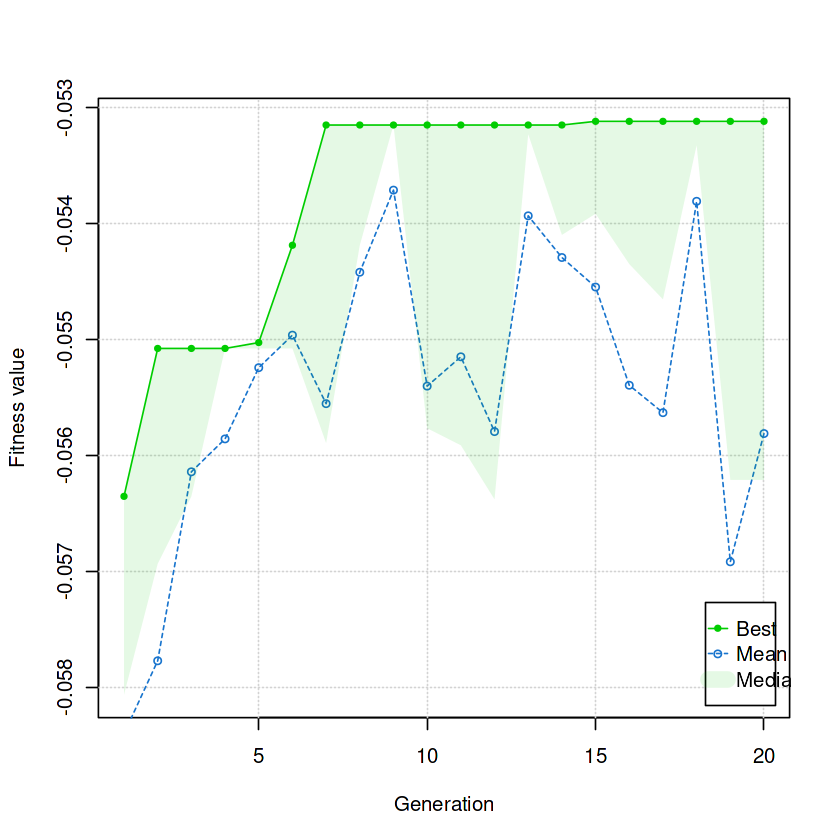

In [9]:
tic()
GA=ga(type='real-valued',fitness=function(x) fit_DT(x[1],x[2],x[3],x[4],x[5]),
      lower=c(0,0,0,0,1e-5),upper=c(0.5,0.5,0.5,0.5,1e-2),maxiter=20,popSize=5,seed=1234,pmutation=0.025,keepBest=TRUE)
summary(GA)
plot(GA)
toc()

In [10]:
summary(GA)

── Genetic Algorithm ─────────────────── 

GA settings: 
Type                  =  real-valued 
Population size       =  5 
Number of generations =  20 
Elitism               =  1 
Crossover probability =  0.8 
Mutation probability  =  0.025 
Search domain = 
       x1  x2  x3  x4    x5
lower 0.0 0.0 0.0 0.0 1e-05
upper 0.5 0.5 0.5 0.5 1e-02

GA results: 
Iterations             = 20 
Fitness function value = -0.05311659 
Solution = 
             x1         x2        x3        x4          x5
[1,] 0.04108997 0.09526625 0.2290747 0.4862567 0.003549904

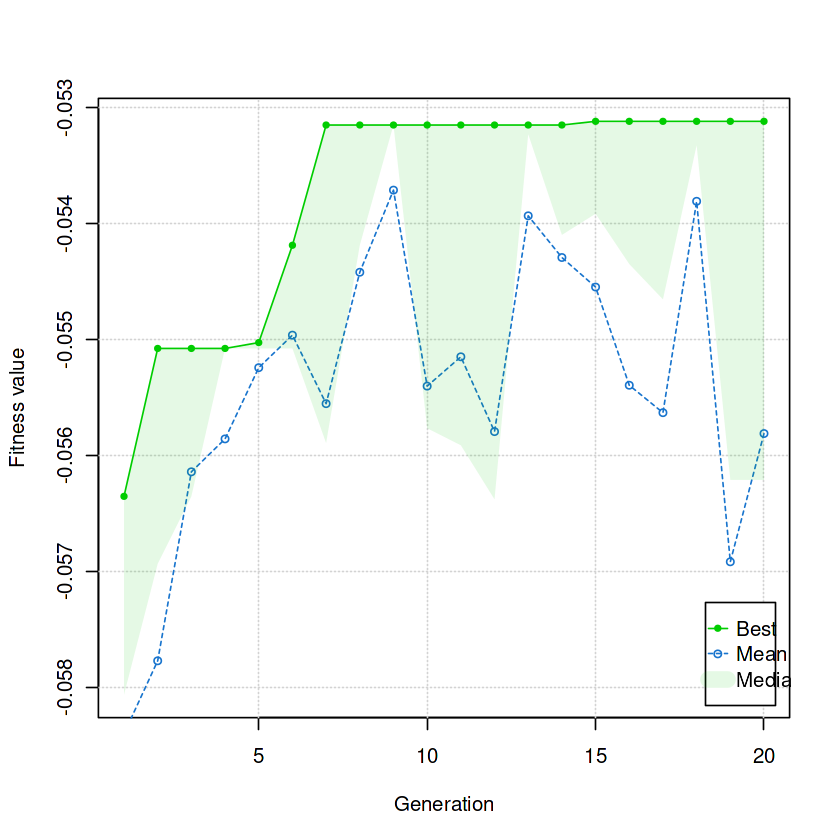

In [11]:
plot(GA)